# SACOG intake survey analysis

In [1]:
import pandas as pd, numpy as np, os, seaborn as sns, matplotlib.pyplot as plt, matplotlib.ticker as ticker, \
json, sys, site, pylogit as pl, pandas as pd, plotly, plotly.graph_objects as go, matplotlib as mpl
import fiona, descartes,  shapely, geopandas as gpd, contextily as ctx
from matplotlib import rcParams
from datetime import date
%matplotlib inline
pd.set_option('display.precision',3)

## Part 0: load the data

In [2]:
## this first file contains all the 2020 survey responses
sacog = pd.read_excel('sacog_recoded.xlsx', encoding = 'utf-8')

## this second file contains the means by which to link the 2020 survey-takes to the 2018 responses. 
## Anyone on the CPHS can see the 2020 email addresses and the anonymized HHIDs are not PII so that is ok.
x_walk = pd.read_excel('hhid_email_list_04242020.xlsx', sheet_name='intake')

In [3]:
## Here we merge the crosswalk email addresses and HHIDs into the survey data so that I can link them in another workbook
sacog = sacog.merge(x_walk, how = 'inner', left_on = 'Recipient Email', right_on = 'email')

## Part 1: Data Checks

In [387]:
sacog['HousingType'].value_counts()

Detached single-family home                         217
Attached single-family home                          41
Building/house with fewer than 10 units              32
Building with between 10 and 100 units               19
Building with more than 100 units                     5
Prefer not to answer                                  3
Mobile home/RV/Trailer                                3
condominiums                                          1
Apartment complex with more than 600 apartments.      1
duplex                                                1
Detached home on 50 acres                             1
Senior living complex                                 1
large complex of buildings with 4 units               1
Duplex                                                1
Name: HousingType, dtype: int64

In [40]:
sacog['CountyofResidence'].value_counts()

Sacramento    213
Yolo           60
Placer         30
El Dorado      20
Yuba            2
Humboldt        1
Sutter          1
Name: CountyofResidence, dtype: int64

In [380]:
sacog[sacog['MovedSince2018'] == 'Yes'][['CountyofResidence','County2018']]

CountyofResidence  County2018
1            Humboldt  Sacramento
4                Yolo        Yolo
5          Sacramento  Sacramento
10         Sacramento        Yolo
12         Sacramento  Sacramento
30         Sacramento  Sacramento
34               Yolo  Sacramento
47         Sacramento  Sacramento
50         Sacramento  Sacramento
66         Sacramento  Sacramento
69               Yolo        Yolo
75         Sacramento  Sacramento
81         Sacramento  Sacramento
83         Sacramento  Sacramento
84         Sacramento  Sacramento
94               Yolo        Yolo
117         El Dorado   El Dorado
118        Sacramento  Sacramento
119        Sacramento  Sacramento
120        Sacramento  Sacramento
128        Sacramento  Sacramento
131        Sacramento  Sacramento
132        Sacramento  Sacramento
133        Sacramento  Sacramento
136              Yolo  Sacramento
137        Sacramento  Sacramento
143        Sacramento  Sacramento
162        Sacramento  Sacramento
170              Yolo        Yolo
171              Yolo        Yolo
172              Yolo  Sacramento
190        Sacramento  Sacramento
210        Sacramento  Sacramento
214            Placer      Placer
216            Placer  Sacramento
227        Sacramento  Sacramento
246        Sacramento  Sacramento
249        Sacramento  Sacramento
272        Sacramento  Sacramento
280              Yolo        Yolo
281              Yolo  Sacramento
296              Yolo        Yolo
297        Sacramento  Sacramento
298        Sacramento  Sacramento
314              Yolo        Yolo
317        Sacramento  Sacramento
324              Yolo  Sacramento

In [385]:
sacog['May-InStore-Distance-PreparedFood'].value_counts()

No Response           140
1 - 3 miles            68
3 - 5 miles            46
1/2 mile - 1 mile      19
5 -10 miles            19
1/4 - 1/2 mile         15
Less than 1/4 mile      9
10 - 25 miles           9
25 - 50 miles           2
Name: May-InStore-Distance-PreparedFood, dtype: int64

In [383]:
sacog['May-Pickup-Distance-PreparedFood'].value_counts()

No Response           232
1 - 3 miles            32
3 - 5 miles            19
5 -10 miles            14
1/2 mile - 1 mile      10
1/4 - 1/2 mile          8
10 - 25 miles           6
Less than 1/4 mile      3
25 - 50 miles           2
Don't know              1
Name: May-Pickup-Distance-PreparedFood, dtype: int64

In [386]:
sacog['May-InStore-Distance-Groceries'].value_counts()

1 - 3 miles              105
3 - 5 miles               53
5 -10 miles               39
No Response               38
1/2 mile - 1 mile         32
10 - 25 miles             25
Less than 1/4 mile        15
1/4 - 1/2 mile            13
25 - 50 miles              5
Greater than 50 miles      2
Name: May-InStore-Distance-Groceries, dtype: int64

In [384]:
sacog['May-Pickup-Distance-Groceries'].value_counts()

No Response          288
1 - 3 miles           14
3 - 5 miles            8
5 -10 miles            8
1/2 mile - 1 mile      4
10 - 25 miles          3
1/4 - 1/2 mile         2
Name: May-Pickup-Distance-Groceries, dtype: int64

In [32]:
sacog['JanFeb-ShareShopping'].value_counts(), sacog['May-ShareShopping'].value_counts()

(Yes, for some shopping needs    102
 Yes, for all shopping needs      86
 No Response                      80
 No                               59
 Name: JanFeb-ShareShopping, dtype: int64, Yes, for some shopping needs    86
 Yes, for all shopping needs     86
 No Response                     80
 No                              75
 Name: May-ShareShopping, dtype: int64)

In [4]:
sacog['ShoppingOnBehalf'].value_counts()

No     183
Yes    144
Name: ShoppingOnBehalf, dtype: int64

In [36]:
shopping = ['May-ShoppingForImmediateFamily','May-ShoppingForExtendedFamily','May-ShoppingForNonFamily',\
            'May-ShoppingForColleagues','May-ShoppingForOther','May-ShoppingForOtherType']

sacog[shopping].sum()

May-ShoppingForImmediateFamily    111
May-ShoppingForExtendedFamily      24
May-ShoppingForNonFamily           31
May-ShoppingForColleagues           3
May-ShoppingForOther                4
dtype: int64

In [9]:
sacog['shopping_non_imm_fam'] = sacog['May-ShoppingForExtendedFamily'] + sacog['May-ShoppingForNonFamily'] + sacog['May-ShoppingForOther'] + sacog['May-ShoppingForColleagues']
sacog['shopping_non_imm_fam'].value_counts()
sacog['May-ShoppingForAnyNonImmediateFam'] = [1 if x > 0 else 0 for x in sacog['shopping_non_imm_fam']]

In [5]:
sacog['Change-Shopping-InStoreForSomeoneElse-Groceries'].value_counts()

No             249
Yes             51
No Response     27
Name: Change-Shopping-InStoreForSomeoneElse-Groceries, dtype: int64

In [377]:
sacog.columns.to_list()

['Unnamed: 0',
 'Start Date',
 'End Date',
 'Response Type',
 'IP Address',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'Recorded Date',
 'Response ID',
 'Recipient Last Name',
 'Recipient First Name',
 'Recipient Email',
 'External Data Reference',
 'Location Latitude',
 'Location Longitude',
 'Distribution Channel',
 'User Language',
 'Q_RecaptchaScore',
 'Participant Consent',
 'What is your age group?',
 'CountyofResidence',
 'Residence-ZipCode',
 'Residence-CrossStreet1',
 'Residence-CrossStreet2',
 'SACOG2018Method',
 'LiveWithHouseholdMember',
 'MovedSince2018',
 'County2018',
 'Recontacted',
 'OtherFollowups',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Me

In [376]:
sacog.MovedSince2018.value_counts()

No     280
Yes     47
Name: MovedSince2018, dtype: int64

### 1.1 Responses per household

In [7]:
## Here I am looking at how many representatives from each HH there are.
## There are 300 respondents answering on behalf of their household, 12 two-persons, and one three-person
sacog.groupby(['hhidR']).agg('count').Progress.value_counts()

1    300
2     12
3      1
Name: Progress, dtype: int64

In [51]:
## Here I am looking to see if there was any explanation given as to the responses for personal vs. HH-level reporting
## We asked them to report on behalf of the household, so if the numbers of trips don't match, I will need to consider what to do
sacog[sacog.duplicated(['hhidR'], keep=False)][['hhidR','JanFeb-ShoppingExplanation','SurveyFeedback']]

hhidR                         JanFeb-ShoppingExplanation  \
6    18601044889                                                NaN   
7    18611100798                                                NaN   
21   18601044889                                                NaN   
39   18601153584                  More stores were open in Jan/Feb.   
59   18601117353                                                NaN   
61   18601117353                                                NaN   
72   18601051099                                                NaN   
87   18601153584                                                NaN   
94   18611167410                                                NaN   
112  18601082250                                                NaN   
113  18601082250                                                NaN   
115  18601051099                                                NaN   
120  18601065355                                                NaN   
132  18601065355                                                NaN   
136  18601167521  I used to do all of my grocery shopping on a m...   
172  18601167521                                                NaN   
181  18611100798                                                NaN   
201  18601161282                                                NaN   
204  18601056708                                                NaN   
206  18601056708                                                NaN   
230  18601161282                                                NaN   
250  18601115598                                                NaN   
255  18601115598                                                NaN   
265  18601161282                                                NaN   
296  18611167410                                                NaN   
308  18611087673  Prior to covid-19, I did the majority of the s...   
309  18611087673  The two other people in my household are in th...   

                                        SurveyFeedback  
6                                                  NaN  
7                                                  NaN  
21                                                 NaN  
39                                                 NaN  
59                                                 NaN  
61                                                 NaN  
72                                                 NaN  
87   Thank you for letting me participate in the su...  
94                                                 NaN  
112  Near the beginning, there was a question about...  
113  on some of the trips, there was not an option ...  
115                                                NaN  
120                                                NaN  
132                                                NaN  
136                                                NaN  
172                                                NaN  
181                                                NaN  
201                                         Grace  Liu  
204                                                NaN  
206                                                NaN  
230                                                NaN  
250                                                NaN  
255                                                NaN  
265                                                NaN  
296                                                NaN  
308  The survey was a bit confusing regarding the t...  
309  I was surprised you didn’t have Medical Profes...

## Part 2: Example code for viewing responses

In [ ]:
list(sacog.columns)

### 2.1 Commuting trips and changes

In [5]:
## Mask respondents who didn't answer a question so they're not included in averages and distributions
mask_may = sacog['May-Trips-Commuting'].isin([-9998])
mask_jan = sacog['JanFeb-TripNumber-Commuting'].isin([-9998])
sacog[~mask_may]['May-Trips-Commuting'].describe(), sacog[~mask_jan]['JanFeb-TripNumber-Commuting'].describe()

(count    312.000
 mean       1.535
 std        3.020
 min        0.000
 25%        0.000
 50%        0.000
 75%        2.000
 max       11.000
 Name: May-Trips-Commuting, dtype: float64, count    314.000
 mean       6.188
 std        4.420
 min        0.000
 25%        0.000
 50%        8.000
 75%       10.000
 max       11.000
 Name: JanFeb-TripNumber-Commuting, dtype: float64)

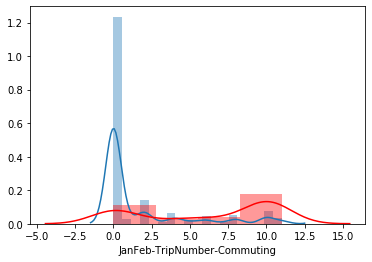

In [6]:
sns.distplot(sacog[~mask_may]['May-Trips-Commuting'])
sns.distplot(sacog[~mask_jan]['JanFeb-TripNumber-Commuting'], color = 'red')

### 2.2 Tele-commuting

In [57]:
## Mask respondents who didn't answer a question so they're not included in averages and distributions
mask_may = sacog['May-TelecommutingDays'].isin([-9998,-1])
mask_jan = sacog['JanFeb-TelecommutingDays'].isin([-9998,-1])
sacog[~mask_may]['May-TelecommutingDays'].describe(), sacog[~mask_jan]['JanFeb-TelecommutingDays'].describe()

(count    229.000
 mean       3.485
 std        2.227
 min        0.000
 25%        1.000
 50%        5.000
 75%        5.000
 max        6.000
 Name: May-TelecommutingDays, dtype: float64, count    327.000
 mean       0.737
 std        1.646
 min        0.000
 25%        0.000
 50%        0.000
 75%        0.000
 max        6.000
 Name: JanFeb-TelecommutingDays, dtype: float64)

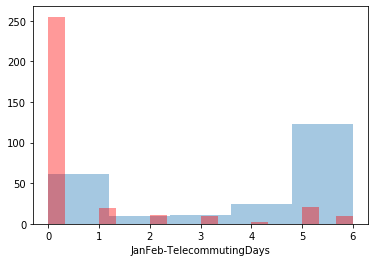

In [59]:
## we see a lot more tele-commuting in may, not surprising
sns.distplot(sacog[~mask_may]['May-TelecommutingDays'], kde = False)
sns.distplot(sacog[~mask_jan]['JanFeb-TelecommutingDays'], color = 'red', kde = False)

### 2.3 Grocery trips and e-commerce purchases

In [45]:
mask_may1 = sacog['May-InStore-Trips-Groceries'].isin([-9998])
mask_may2 = sacog['May-ECommerce-Orders-Groceries'].isin([-9998])
mask_may3 = sacog['PastYear-ECommerce-Frequency-Groceries'].isin([-9998])
mask_jan1 = sacog['Change-Shopping-TripsToStore-Groceries'].isin([-9998])
mask_jan2 = sacog['Change-Shopping-ECommercePurchases-Groceries'].isin([-9998])

sacog[~mask_may1]['May-InStore-Trips-Groceries'].describe(), \
sacog[~mask_may2]['May-ECommerce-Orders-Groceries'].describe(),\
sacog[~mask_may3]['PastYear-ECommerce-Frequency-Groceries'].value_counts(),\
sacog[~mask_jan1]['Change-Shopping-TripsToStore-Groceries'].value_counts(), \
sacog[~mask_jan2]['Change-Shopping-ECommercePurchases-Groceries'].value_counts()

(count    318.000
 mean       2.881
 std        2.065
 min        0.000
 25%        2.000
 50%        2.000
 75%        4.000
 max       11.000
 Name: May-InStore-Trips-Groceries, dtype: float64, count    258.000
 mean       0.450
 std        1.032
 min        0.000
 25%        0.000
 50%        0.000
 75%        1.000
 max       11.000
 Name: May-ECommerce-Orders-Groceries, dtype: float64, Never                          130
 Almost never                    66
 No Response                     35
 Less than 1 time per month      32
 Less than 1 time per week       25
 About 1 time per week           23
 2 - 3 times per week            14
 More than 5 times per week       1
 3 - 5 times per week             1
 Name: PastYear-ECommerce-Frequency-Groceries, dtype: int64, Less           195
 No change       87
 More            38
 No Response      7
 Name: Change-Shopping-TripsToStore-Groceries, dtype: int64, No change      209
 More            87
 Less            22
 No Response      9
 Na

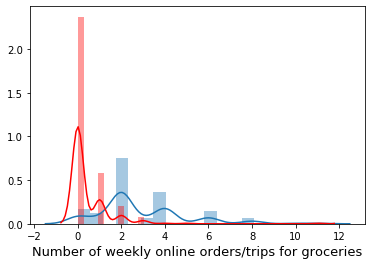

In [62]:
## this is a quick way to look at the difference in trips vs. purchases
sns.distplot(sacog[~mask_may1]['May-InStore-Trips-Groceries'])
sns.distplot(sacog[~mask_may2]['May-ECommerce-Orders-Groceries'], color = 'red')
plt.xlabel('Number of weekly online orders/trips for groceries', fontsize = 13);

In [115]:
sacog[sacog['PastYear-ECommerce-Frequency-Groceries'] == 'Never']['May-ECommerce-Orders-Groceries'].value_counts()

 0       83
-9998    29
 1       11
 2        5
 4        1
 3        1
Name: May-ECommerce-Orders-Groceries, dtype: int64

In [294]:
len(sacog[sacog['May-ECommerce-Orders-Groceries']>0]['May-ECommerce-Orders-Groceries'])

71

In [48]:
## one person made more than 10 grocery orders in a week, I just wanted to see what was going on
sacog[sacog['May-ECommerce-Orders-Groceries']>10]['May-ECommerce-Orders-PreparedFood']

48    2
Name: May-ECommerce-Orders-PreparedFood, dtype: int64

### 2.4 Prepared food trips and e-commerce orders

In [63]:
mask_may1 = sacog['May-InStore-Trips-PreparedFood'].isin([-9998])
mask_may2 = sacog['May-ECommerce-Orders-PreparedFood'].isin([-9998])
mask_may3 = sacog['PastYear-ECommerce-Frequency-PreparedFood'].isin([-9998])
mask_jan1 = sacog['Change-Shopping-TripsToStore-PreparedFood'].isin([-9998])
mask_jan2 = sacog['Change-Shopping-ECommercePurchases-PreparedFood'].isin([-9998])

sacog[~mask_may1]['May-InStore-Trips-PreparedFood'].describe(), \
sacog[~mask_may2]['May-ECommerce-Orders-PreparedFood'].describe(),\
sacog[~mask_may3]['PastYear-ECommerce-Frequency-PreparedFood'].value_counts(),\
sacog[~mask_jan1]['Change-Shopping-TripsToStore-PreparedFood'].value_counts(), \
sacog[~mask_jan2]['Change-Shopping-ECommercePurchases-PreparedFood'].value_counts()

(count    305.000
 mean       1.856
 std        2.237
 min        0.000
 25%        0.000
 50%        2.000
 75%        2.000
 max       11.000
 Name: May-InStore-Trips-PreparedFood, dtype: float64, count    264.000
 mean       0.989
 std        1.274
 min        0.000
 25%        0.000
 50%        1.000
 75%        1.000
 max        8.000
 Name: May-ECommerce-Orders-PreparedFood, dtype: float64, Never                          87
 Less than 1 time per month     56
 About 1 time per week          51
 Less than 1 time per week      43
 Almost never                   36
 No Response                    33
 2 - 3 times per week           17
 More than 5 times per week      2
 3 - 5 times per week            2
 Name: PastYear-ECommerce-Frequency-PreparedFood, dtype: int64, Less           150
 No change      117
 More            52
 No Response      8
 Name: Change-Shopping-TripsToStore-PreparedFood, dtype: int64, No change      166
 More           112
 Less            34
 No Response     15


In [113]:
sacog['PastYear-ECommerce-Frequency-PreparedFood'].value_counts()

Never                          87
Less than 1 time per month     56
About 1 time per week          51
Less than 1 time per week      43
Almost never                   36
No Response                    33
2 - 3 times per week           17
3 - 5 times per week            2
More than 5 times per week      2
Name: PastYear-ECommerce-Frequency-PreparedFood, dtype: int64

In [114]:
sacog[sacog['PastYear-ECommerce-Frequency-PreparedFood'] == 'Never']['May-ECommerce-Orders-PreparedFood'].value_counts()

 0       45
-9998    20
 1       17
 2        3
 8        1
 3        1
Name: May-ECommerce-Orders-PreparedFood, dtype: int64

In [295]:
len(sacog[sacog['May-ECommerce-Orders-PreparedFood']>0]['May-ECommerce-Orders-PreparedFood'])

147

22 new users of prepared food e-commerce ordering.

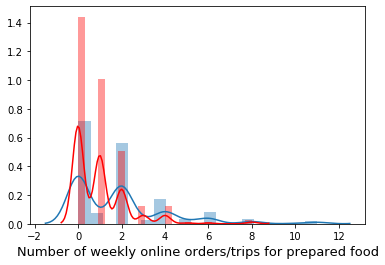

In [64]:
## this is a quick way to look at the difference in trips vs. purchases
sns.distplot(sacog[~mask_may1]['May-InStore-Trips-PreparedFood'])
sns.distplot(sacog[~mask_may2]['May-ECommerce-Orders-PreparedFood'], color = 'red')
plt.xlabel('Number of weekly online orders/trips for prepared food', fontsize = 13);

### Clothing trips and e-commerce orders

In [65]:
mask_may1 = sacog['May-InStore-Trips-Clothing'].isin([-9998])
mask_may2 = sacog['May-ECommerce-Orders-Clothing'].isin([-9998])
mask_may3 = sacog['PastYear-ECommerce-Frequency-Clothing'].isin([-9998])
mask_jan1 = sacog['Change-Shopping-TripsToStore-Clothing'].isin([-9998])
mask_jan2 = sacog['Change-Shopping-ECommercePurchases-Clothing'].isin([-9998])

sacog[~mask_may1]['May-InStore-Trips-Clothing'].describe(), \
sacog[~mask_may2]['May-ECommerce-Orders-Clothing'].describe(),\
sacog[~mask_may3]['PastYear-ECommerce-Frequency-Clothing'].value_counts(),\
sacog[~mask_jan1]['Change-Shopping-TripsToStore-Clothing'].value_counts(), \
sacog[~mask_jan2]['Change-Shopping-ECommercePurchases-Clothing'].value_counts()

(count    266.000
 mean       0.060
 std        0.342
 min        0.000
 25%        0.000
 50%        0.000
 75%        0.000
 max        3.000
 Name: May-InStore-Trips-Clothing, dtype: float64, count    254.000
 mean       0.622
 std        1.282
 min        0.000
 25%        0.000
 50%        0.000
 75%        1.000
 max       11.000
 Name: May-ECommerce-Orders-Clothing, dtype: float64, Less than 1 time per month     164
 Less than 1 time per week       45
 No Response                     40
 Almost never                    38
 Never                           24
 About 1 time per week            8
 2 - 3 times per week             5
 More than 5 times per week       2
 3 - 5 times per week             1
 Name: PastYear-ECommerce-Frequency-Clothing, dtype: int64, No change      185
 Less           108
 No Response     21
 More            13
 Name: Change-Shopping-TripsToStore-Clothing, dtype: int64, No change      227
 More            46
 Less            32
 No Response     22
 Name: 

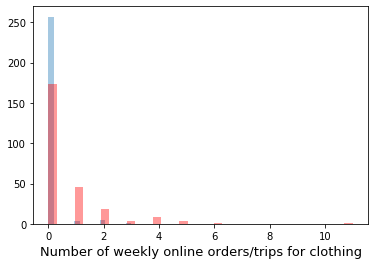

In [68]:
## this is a quick way to look at the difference in trips vs. purchases
sns.distplot(sacog[~mask_may1]['May-InStore-Trips-Clothing'], kde = False)
sns.distplot(sacog[~mask_may2]['May-ECommerce-Orders-Clothing'], kde = False, color = 'red')
plt.xlabel('Number of weekly online orders/trips for clothing', fontsize = 13);

In [297]:
sacog[sacog['PastYear-ECommerce-Frequency-Clothing'] == 'Never']['May-ECommerce-Orders-Clothing'].value_counts()

 0       14
-9998    10
Name: May-ECommerce-Orders-Clothing, dtype: int64

In [298]:
sacog['PastYear-ECommerce-Frequency-Clothing'].value_counts()

Less than 1 time per month     164
Less than 1 time per week       45
No Response                     40
Almost never                    38
Never                           24
About 1 time per week            8
2 - 3 times per week             5
More than 5 times per week       2
3 - 5 times per week             1
Name: PastYear-ECommerce-Frequency-Clothing, dtype: int64

In [296]:
len(sacog[sacog['May-ECommerce-Orders-Clothing']>0]['May-ECommerce-Orders-Clothing'])

81

## Part 3: E-commerce and shopping trips for all categories

### 3.0 Response trimming

#### 3.0.1 If no longer in sacog region

one individual is out of the region

In [451]:
sacog[~(sacog.CountyofResidence =='Humboldt')]

Unnamed: 0          Start Date            End Date Response Type  \
0             0 2020-05-25 12:07:41 2020-05-25 12:40:19    IP Address   
2             2 2020-05-25 12:15:34 2020-05-25 12:43:10    IP Address   
3             3 2020-05-25 12:13:15 2020-05-25 12:47:12    IP Address   
4             4 2020-05-25 12:16:28 2020-05-25 12:47:25    IP Address   
5             5 2020-05-25 12:21:20 2020-05-25 12:48:37    IP Address   
..          ...                 ...                 ...           ...   
322         322 2020-05-31 18:36:11 2020-05-31 20:15:14    IP Address   
323         323 2020-05-31 20:05:38 2020-05-31 21:23:27    IP Address   
324         324 2020-06-01 10:03:19 2020-06-01 10:53:10    IP Address   
325         325 2020-06-01 03:35:38 2020-06-01 12:01:49    IP Address   
326         326 2020-05-28 23:01:43 2020-06-05 08:47:27    IP Address   

         IP Address  Progress  Duration (in seconds)  Finished  \
0    98.208.112.200       100                   1957      True   
2     107.138.66.44       100                   1655      True   
3    23.114.218.168       100                   2036      True   
4        73.2.34.66       100                   1856      True   
5     12.227.100.80       100                   1636      True   
..              ...       ...                    ...       ...   
322   67.187.138.65       100                   5943      True   
323   99.105.32.108       100                   4669      True   
324  149.136.17.252       100                   2990      True   
325   23.114.37.167       100                  30370      True   
326  104.220.150.42       100                 639943      True   

              Recorded Date        Response ID  ...  May-No-ECommerce-Orders  \
0   2020-05-25 12:40:20.264  R_3HLKBXhTIWgpd5v  ...                        0   
2   2020-05-25 12:43:11.046  R_wXWh8mxuoPtnAWt  ...                        1   
3   2020-05-25 12:47:13.365  R_2TNwp9PZ6T9eKdl  ...                        0   
4   2020-05-25 12:47:26.445  R_1ouIsItTUyGkZBh  ...                        0   
5   2020-05-25 12:48:38.811  R_2tAaICdvf84OC6T  ...                        1   
..                      ...                ...  ...                      ...   
322 2020-05-31 20:15:15.364  R_2wp0SGwDj5EI5Vt  ...                        0   
323 2020-05-31 21:23:28.470  R_QcrB2aYNBqcQXg5  ...                        0   
324 2020-06-01 10:53:11.344  R_2CJHppa3U27Oxe2  ...                        1   
325 2020-06-01 12:01:50.957  R_1liC70nsJ8qXqbW  ...                        0   
326 2020-06-05 08:47:28.513  R_31LydsXQsx3GG1y  ...                        0   

     May-ECommerce-Orders>0 May-Curbside-Food  May-InStore-Food  \
0                         1                 0                 0   
2                         0                 0                 0   
3                         1                 2                 0   
4                         1                 1                 0   
5                         0                 2                 0   
..                      ...               ...               ...   
322                       1                 2                 2   
323                       1                 0                 0   
324                       0                 0                 0   
325                       1                 2                 0   
326                       1                 0                 0   

     May-ToHome-Food  May-ToNonHome-Food May-Curbside-NonFood  \
0                  1                   0                    0   
2                  0                   0                    0   
3                  0                   0                    2   
4                  1                   0                    0   
5                  2                   0                    0   
..               ...                 ...                  ...   
322                0                   0                    1   
323                0                   0         

### 3.1 E-commerce

#### 3.1.1 Purchasing

In [10]:
## create new bundled columns to match 2018 data
sacog['May-Food-ECommerce-Orders'] = sacog['May-ECommerce-Orders-PreparedFood'].replace({-9998:0}) +\
sacog['May-ECommerce-Orders-Groceries'].replace({-9998:0}) + sacog['May-ECommerce-Orders-OtherFood'].replace({-9998:0})

sacog['May-NonFood-ECommerce-Orders'] = sacog['May-ECommerce-Orders-PaperCleaning'].replace({-9998:0}) +\
sacog['May-ECommerce-Orders-Clothing'].replace({-9998:0}) + sacog['May-ECommerce-Orders-HomeOffice'].replace({-9998:0}) +\
sacog['May-ECommerce-Orders-Medication'].replace({-9998:0}) + sacog['May-ECommerce-Orders-ChildcareItems'].replace({-9998:0}) +\
sacog['May-ECommerce-Orders-Other'].replace({-9998:0})

In [11]:
e_comm_order_cols = ['May-Food-ECommerce-Orders', 'May-NonFood-ECommerce-Orders',\
                     'May-ECommerce-Orders-PreparedFood','May-ECommerce-Orders-Groceries',\
                        'May-ECommerce-Orders-OtherFood','May-ECommerce-Orders-PaperCleaning',\
                        'May-ECommerce-Orders-Clothing','May-ECommerce-Orders-HomeOffice',\
                        'May-ECommerce-Orders-Medication','May-ECommerce-Orders-ChildcareItems',\
                        'May-ECommerce-Orders-Other']

In [12]:
## total number of purchases is below, not necessarily days with purchase
sacog[e_comm_order_cols] = sacog[e_comm_order_cols].replace({-9998:0})
sacog[e_comm_order_cols].describe()

May-Food-ECommerce-Orders  May-NonFood-ECommerce-Orders  \
count                    327.000                       327.000   
mean                       1.287                         1.587   
std                        1.747                         2.782   
min                        0.000                         0.000   
25%                        0.000                         0.000   
50%                        1.000                         1.000   
75%                        2.000                         2.000   
max                       13.000                        23.000   

       May-ECommerce-Orders-PreparedFood  May-ECommerce-Orders-Groceries  \
count                            327.000                         327.000   
mean                               0.798                           0.355   
std                                1.209                           0.935   
min                                0.000                           0.000   
25%                                0.000                           0.000   
50%                                0.000                           0.000   
75%                                1.000                           0.000   
max                                8.000                          11.000   

       May-ECommerce-Orders-OtherFood  May-ECommerce-Orders-PaperCleaning  \
count                         327.000                             327.000   
mean                            0.135                               0.159   
std                             0.502                               0.559   
min                             0.000                               0.000   
25%                             0.000                               0.000   
50%                             0.000                               0.000   
75%                             0.000                               0.000   
max                             6.000                               5.000   

       May-ECommerce-Orders-Clothing  May-ECommerce-Orders-HomeOffice  \
count                        327.000                          327.000   
mean                           0.483                            0.135   
std                            1.159                            0.450   
min                            0.000                            0.000   
25%                            0.000                            0.000   
50%                            0.000                            0.000   
75%                            0.000                            0.000   
max                           11.000                            3.000   

       May-ECommerce-Orders-Medication  May-ECommerce-Orders-ChildcareItems  \
count                          327.000                              327.000   
mean                             0.263                                0.159   
std                              0.585                                0.722   
min                              0.000                                0.000   
25%                              0.000                                0.000   
50%                              0.000                                0.000   
75%                              0.000                                0.000   
max                              3.000                                8.000   

       May-ECommerce-Orders-Other  
count                     327.000  
mean                        0.388  
std                         1.238  
min                         0.000  
25%                         0.000  
50%                         0.000  
75%                         0.000  
max                        11.000

#### 3.1.2 Purchasing channels

In [13]:
sacog['May-Food-ECommerce-CallIn'] = sacog['May-CallIn-PreparedFood'].replace({-9998:0}) +\
sacog['May-CallIn-Groceries'].replace({-9998:0}) + sacog['May-CallIn-OtherFood'].replace({-9998:0})

sacog['May-NonFood-ECommerce-CallIn'] = sacog['May-CallIn-PaperCleaning'].replace({-9998:0}) +\
sacog['May-CallIn-Clothing'].replace({-9998:0}) + sacog['May-CallIn-HomeOffice'].replace({-9998:0}) +\
sacog['May-CallIn-Medication'].replace({-9998:0}) + sacog['May-CallIn-ChildcareItems'].replace({-9998:0}) +\
sacog['May-CallIn-Other'].replace({-9998:0})

##
sacog['May-Food-ECommerce-MobileApp'] = sacog['May-MobileApp-PreparedFood'].replace({-9998:0}) +\
sacog['May-MobileApp-Groceries'].replace({-9998:0}) + sacog['May-MobileApp-OtherFood'].replace({-9998:0})

sacog['May-NonFood-ECommerce-MobileApp'] = sacog['May-MobileApp-PaperCleaning'].replace({-9998:0}) +\
sacog['May-MobileApp-Clothing'].replace({-9998:0}) + sacog['May-MobileApp-HomeOffice'].replace({-9998:0}) +\
sacog['May-MobileApp-Medication'].replace({-9998:0}) + sacog['May-MobileApp-ChildcareItems'].replace({-9998:0}) +\
sacog['May-MobileApp-Other'].replace({-9998:0})

##
sacog['May-Food-ECommerce-Browser'] = sacog['May-Browser-PreparedFood'].replace({-9998:0}) +\
sacog['May-Browser-Groceries'].replace({-9998:0}) + sacog['May-Browser-OtherFood'].replace({-9998:0})

sacog['May-NonFood-ECommerce-Browser'] = sacog['May-Browser-PaperCleaning'].replace({-9998:0}) +\
sacog['May-Browser-Clothing'].replace({-9998:0}) + sacog['May-Browser-HomeOffice'].replace({-9998:0}) +\
sacog['May-Browser-Medication'].replace({-9998:0}) + sacog['May-Browser-ChildcareItems'].replace({-9998:0}) +\
sacog['May-Browser-Other'].replace({-9998:0})

In [14]:
e_comm_channel_cols = [k for k in list(sacog.columns) if ('CallIn' in k) or ('MobileApp' in k) or ('Browser' in k)]

In [15]:
sacog[e_comm_channel_cols] = sacog[e_comm_channel_cols].replace({-9998:0})
sacog[e_comm_channel_cols].describe()

May-CallIn-PreparedFood  May-CallIn-Groceries  May-CallIn-OtherFood  \
count                  327.000               327.000               327.000   
mean                     0.312                 0.012                 0.009   
std                      0.674                 0.135                 0.095   
min                      0.000                 0.000                 0.000   
25%                      0.000                 0.000                 0.000   
50%                      0.000                 0.000                 0.000   
75%                      0.000                 0.000                 0.000   
max                      6.000                 2.000                 1.000   

       May-CallIn-PaperCleaning  May-CallIn-Clothing  May-CallIn-HomeOffice  \
count                     327.0              327.000                327.000   
mean                        0.0                0.009                  0.003   
std                         0.0                0.124                  0.055   
min                         0.0                0.000                  0.000   
25%                         0.0                0.000                  0.000   
50%                         0.0                0.000                  0.000   
75%                         0.0                0.000                  0.000   
max                         0.0                2.000                  1.000   

       May-CallIn-Medication  May-CallIn-ChildcareItems  May-CallIn-Other  \
count                327.000                    327.000           327.000   
mean                   0.049                      0.009             0.003   
std                    0.267                      0.166             0.055   
min                    0.000                      0.000             0.000   
25%                    0.000                      0.000             0.000   
50%                    0.000                      0.000             0.000   
75%                    0.000                      0.000             0.000   
max                    3.000                      3.000             1.000   

       May-MobileApp-PreparedFood  ...  May-Browser-HomeOffice  \
count                     327.000  ...                 327.000   
mean                        0.431  ...                   0.107   
std                         1.086  ...                   0.440   
min                         0.000  ...                   0.000   
25%                         0.000  ...                   0.000   
50%                         0.000  ...                   0.000   
75%                         0.000  ...                   0.000   
max                        11.000  ...                   5.000   

       May-Browser-Medication  May-Browser-ChildcareItems  May-Browser-Other  \
count                 327.000                     327.000            327.000   
mean                    0.217                       0.058              0.260   
std                     0.606                       0.303              0.877   
min                     0.000                       0.000              0.000   
25%                     0.000                       0.000              0.000   
50%                     0.000                       0.000              0.000   
75%                     0.000                       0.000              0.000   
max                     5.000                       3.000              7.000   

       May-Food-ECommerce-CallIn  May-NonFood-ECommerce-CallIn  \
count                    327.000                       327.000   
mean                       0.333                         0.073   
std                        0.698                         0.351   
min                        0.000                         0.000   
25%                        0.000                         0.000   
50%                        0.000                         0.000   
75%                        0.500                         0.000   
max                        6.000                      

#### 3.1.3 Receipt Channels

In [16]:
[k for k in sacog.columns if ('Curbside' in k)or ('ToHome' in k) or ('ToNonHome' in k)\
or ('InStore-P' in k) or ('InStore-G' in k) or ('InStore-OtherF' in k)or ('InStore-C' in k)\
or ('InStore-H' in k) or ('InStore-Me' in k) or ('InStore-Other' in k)]

['May-Curbside-PreparedFood',
 'May-Curbside-Groceries',
 'May-Curbside-OtherFood',
 'May-Curbside-PaperCleaning',
 'May-Curbside-Clothing',
 'May-Curbside-HomeOffice',
 'May-Curbside-Medication',
 'May-Curbside-ChildcareItems',
 'May-Curbside-Other',
 'May-Curbside-OtherType',
 'May-InStore-PreparedFood',
 'May-InStore-Groceries',
 'May-InStore-OtherFood',
 'May-InStore-PaperCleaning',
 'May-InStore-Clothing',
 'May-InStore-HomeOffice',
 'May-InStore-Medication',
 'May-InStore-ChildcareItems',
 'May-InStore-Other',
 'May-InStore-OtherType',
 'May-ToHome-PreparedFood',
 'May-ToHome-Groceries',
 'May-ToHome-OtherFood',
 'May-ToHome-PaperCleaning',
 'May-ToHome-Clothing',
 'May-ToHome-HomeOffice',
 'May-ToHome-Medication',
 'May-ToHome-ChildcareItems',
 'May-ToHome-Other',
 'May-ToHome-OtherType',
 'May-ToNonHome-PreparedFood',
 'May-ToNonHome-Groceries',
 'May-ToNonHome-OtherFood',
 'May-ToNonHome-PaperCleaning',
 'May-ToNonHome-Clothing',
 'May-ToNonHome-HomeOffice',
 'May-ToNonHome-Me

In [17]:
## create new bundled columns to match 2018 data
sacog['May-Curbside-Food'] = sacog['May-Curbside-PreparedFood'].replace({-9998:0}) +\
sacog['May-Curbside-Groceries'].replace({-9998:0}) + sacog['May-Curbside-OtherFood'].replace({-9998:0})

sacog['May-InStore-Food'] = sacog['May-InStore-PreparedFood'].replace({-9998:0}) +\
sacog['May-InStore-Groceries'].replace({-9998:0}) + sacog['May-InStore-OtherFood'].replace({-9998:0})

sacog['May-ToHome-Food'] = sacog['May-ToHome-PreparedFood'].replace({-9998:0}) +\
sacog['May-ToHome-Groceries'].replace({-9998:0}) + sacog['May-ToHome-OtherFood'].replace({-9998:0})

sacog['May-ToNonHome-Food'] = sacog['May-ToNonHome-PreparedFood'].replace({-9998:0}) +\
sacog['May-ToNonHome-Groceries'].replace({-9998:0}) + sacog['May-ToNonHome-OtherFood'].replace({-9998:0})

sacog['May-Curbside-NonFood'] = sacog['May-Curbside-PaperCleaning'].replace({-9998:0}) +\
sacog['May-Curbside-Clothing'].replace({-9998:0}) + sacog['May-Curbside-HomeOffice'].replace({-9998:0}) +\
sacog['May-Curbside-Medication'].replace({-9998:0}) + sacog['May-Curbside-ChildcareItems'].replace({-9998:0}) +\
sacog['May-Curbside-Other'].replace({-9998:0})

sacog['May-InStore-NonFood'] = sacog['May-InStore-PaperCleaning'].replace({-9998:0}) +\
sacog['May-InStore-Clothing'].replace({-9998:0}) + sacog['May-InStore-HomeOffice'].replace({-9998:0}) +\
sacog['May-InStore-Medication'].replace({-9998:0}) + sacog['May-InStore-ChildcareItems'].replace({-9998:0}) +\
sacog['May-InStore-Other'].replace({-9998:0})

sacog['May-ToHome-NonFood'] = sacog['May-ToHome-PaperCleaning'].replace({-9998:0}) +\
sacog['May-ToHome-Clothing'].replace({-9998:0}) + sacog['May-ToHome-HomeOffice'].replace({-9998:0}) +\
sacog['May-ToHome-Medication'].replace({-9998:0}) + sacog['May-ToHome-ChildcareItems'].replace({-9998:0}) +\
sacog['May-ToHome-Other'].replace({-9998:0})

sacog['May-ToNonHome-NonFood'] = sacog['May-ToNonHome-PaperCleaning'].replace({-9998:0}) +\
sacog['May-ToNonHome-Clothing'].replace({-9998:0}) + sacog['May-ToNonHome-HomeOffice'].replace({-9998:0}) +\
sacog['May-ToNonHome-Medication'].replace({-9998:0}) + sacog['May-ToNonHome-ChildcareItems'].replace({-9998:0}) +\
sacog['May-ToNonHome-Other'].replace({-9998:0})

#### 3.1.4 Reported Changes

### 3.2 Shopping Trips

In [18]:
## create new bundled columns to match 2018 data
sacog['May-InStore-Trips-Food'] = sacog['May-InStore-Trips-PreparedFood'].replace({-9998:0}) +\
sacog['May-InStore-Trips-Groceries'].replace({-9998:0}) + sacog['May-InStore-Trips-OtherFood'].replace({-9998:0})

sacog['May-InStore-Trips-NonFood'] = sacog['May-InStore-Trips-PaperCleaning'].replace({-9998:0}) +\
sacog['May-InStore-Trips-Clothing'].replace({-9998:0}) + sacog['May-InStore-Trips-HomeOffice'].replace({-9998:0}) +\
sacog['May-InStore-Trips-Medication'].replace({-9998:0}) + sacog['May-InStore-Trips-ChildcareItems'].replace({-9998:0}) +\
sacog['May-InStore-Trips-Other'].replace({-9998:0})

In [19]:
shopping_trip_cols = [k for k in list(sacog.columns) if 'May-InStore-T' in k]

In [20]:
sacog[shopping_trip_cols] = sacog[shopping_trip_cols].replace({-9998:0})
sacog[shopping_trip_cols].describe()

May-InStore-Trips-PreparedFood  May-InStore-Trips-Groceries  \
count                         327.000                      327.000   
mean                            1.731                        2.801   
std                             2.210                        2.090   
min                             0.000                        0.000   
25%                             0.000                        2.000   
50%                             2.000                        2.000   
75%                             2.000                        4.000   
max                            11.000                       11.000   

       May-InStore-Trips-OtherFood  May-InStore-Trips-PaperCleaning  \
count                      327.000                          327.000   
mean                         0.245                            0.563   
std                          0.670                            1.222   
min                          0.000                            0.000   
25%                          0.000                            0.000   
50%                          0.000                            0.000   
75%                          0.000                            0.000   
max                          4.000                           11.000   

       May-InStore-Trips-Clothing  May-InStore-Trips-HomeOffice  \
count                     327.000                       327.000   
mean                        0.049                         0.098   
std                         0.309                         0.479   
min                         0.000                         0.000   
25%                         0.000                         0.000   
50%                         0.000                         0.000   
75%                         0.000                         0.000   
max                         3.000                         5.000   

       May-InStore-Trips-Medication  May-InStore-Trips-ChildcareItems  \
count                       327.000                           327.000   
mean                          0.398                             0.058   
std                           0.876                             0.322   
min                           0.000                             0.000   
25%                           0.000                             0.000   
50%                           0.000                             0.000   
75%                           0.000                             0.000   
max                           6.000                             2.000   

       May-InStore-Trips-Other  May-InStore-Trips-Food  \
count                  327.000                 327.000   
mean                     0.300                   4.777   
std                      0.934                   3.498   
min                      0.000                   0.000   
25%                      0.000                   2.000   
50%                      0.000                   4.000   
75%                      0.000                   6.000   
max                      6.000                  19.000   

       May-InStore-Trips-NonFood  
count                    327.000  
mean                       1.465  
std                        1.987  
min                        0.000  
25%                        0.000  
50%                        0.000  
75%                        2.000  
max                       12.000

#### 3.2.1 Reported Changes

### 3.3 Future intent

### 3.X Write out trip data for modeling

In [17]:
sacog.columns.to_list()

['Unnamed: 0',
 'Start Date',
 'End Date',
 'Response Type',
 'IP Address',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'Recorded Date',
 'Response ID',
 'Recipient Last Name',
 'Recipient First Name',
 'Recipient Email',
 'External Data Reference',
 'Location Latitude',
 'Location Longitude',
 'Distribution Channel',
 'User Language',
 'Q_RecaptchaScore',
 'Participant Consent',
 'What is your age group?',
 'CountyofResidence',
 'Residence-ZipCode',
 'Residence-CrossStreet1',
 'Residence-CrossStreet2',
 'SACOG2018Method',
 'LiveWithHouseholdMember',
 'MovedSince2018',
 'County2018',
 'Recontacted',
 'OtherFollowups',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Me

In [39]:
cols_dems = ['What is your age group?','CountyofResidence','Residence-ZipCode','MovedSince2018','County2018',
             'Disability-Physical','Disability-Vision','Disability-Hearing','Disability-MentalHealth',
             'Disability-Developmental','Disability-Chronic','Disability-Other','Disability-None',
            'Gender',\
             'May-Employment','May-Employment-Industry','Employment-Changed',\
             'COVID-EmploymentChange-Decrease','COVID-EmploymentChange','Workplace-ZipCode',\
             'PersonalIncome','PersonalIncome-Decreased','PersonalIncome-Increased','HouseholdIncome-Changed',\
            'Children-Under5','Children-5To12','Children-12To18','NumberInHousehold','HousingType',
            'HouseholdIncome','HouseholdIncome-Changed','HousingDeliveries-FrontDesk','HousingDeliveries-Lockers',
             'HousingDeliveries-LoadingDock','HousingDeliveries-CurbSpace','HousingDeliveries-Other','HousingDeliveries-None',
             'HousingDeliveries-PreferNotToAnswer','HousingDeliveries-Mailbox','HousingDeliveries-GatedYard',
             'HousingDeliveries-LockedGatedYard','HousingDeliveries-OtherType','COVIDCarPurchase']

In [34]:
sacog['COVID-EmploymentChange'] = np.where((sacog['Employment-Changed'] ==1) & (sacog['May-Employment'] != sacog['BeforeCOVID-Employment']),1,0)
sacog['COVID-EmploymentChange-Decrease'] = np.where((sacog['Employment-Changed'] ==1) & (sacog['May-Employment'] != sacog['BeforeCOVID-Employment']) & (sacog['May-TelecommutingDays']<1),1,0)

In [38]:
sacog[(sacog['Employment-Changed'] ==1) & (sacog['May-Employment'] != sacog['BeforeCOVID-Employment'])][['May-Employment','BeforeCOVID-Employment','May-TelecommutingDays','COVID-EmploymentChange','COVID-EmploymentChange-Decrease']]

May-Employment  \
0                             Prefer not to answer   
15                                         Retired   
20                                         Retired   
24   Unable to work, receiving monetary assistance   
27                           Single job, part-time   
35              Not employed, not looking for work   
47                  Not employed, looking for work   
54                      Single job, fully employed   
71                                         Retired   
74   Unable to work, receiving monetary assistance   
78                                         Retired   
89                           Single job, part-time   
116                 Not employed, looking for work   
146                          Single job, part-time   
153                 Not employed, looking for work   
159                 Not employed, looking for work   
161  Unable to work, receiving monetary assistance   
211  Unable to work, receiving monetary assistance   
216                 Not employed, looking for work   
220                     Single job, fully employed   
234                       Multiple jobs, part-time   
238             Not employed, not looking for work   
241                 Not employed, looking for work   
256  Unable to work, receiving monetary assistance   
262                 Not employed, looking for work   
270  Unable to work, receiving monetary assistance   
285                       Multiple jobs, part-time   
288                       Multiple jobs, part-time   
310                 Not employed, looking for work   

            BeforeCOVID-Employment  May-TelecommutingDays  \
0       Single job, fully employed                      5   
15           Single job, part-time                     -1   
20        Multiple jobs, part-time                     -1   
24   Multiple jobs, fully employed                     -1   
27      Single job, fully employed                      0   
35           Single job, part-time                     -1   
47      Single job, fully employed                     -1   
54   Multiple jobs, fully employed                      0   
71        Multiple jobs, part-time                     -1   
74      Single job, fully employed                      0   
78           Single job, part-time                     -1   
89      Single job, fully employed                      0   
116     Single job, fully employed                      0   
146       Multiple jobs, part-time                      2   
153     Single job, fully employed                     -1   
159  Multiple jobs, fully employed                     -1   
161  Multiple jobs, fully employed                     -1   
211          Single job, part-time                     -1   
216     Single job, fully employed                     -1   
220  Multiple jobs, fully employed                      5   
234  Multiple jobs, fully employed                      0   
238     Single job, fully employed                      0   
241     Single job, fully employed                     -1   
256       Multiple jobs, part-time                     -1   
262     Single job, fully employed                     -1   
270     Single job, fully employed                     -1   
285          Single job, part-time                      6   
288          Single job, part-time                     -1   
310          Single job, part-time                     -1   

     COVID-EmploymentChange  COVID-EmploymentChange-Decrease  
0                         1                                0  
15                        1                                1  
20                        1                                1  
24                        1                                1  
27                        1                                1  
35                        1                                1  
47                        1                                1  
54                        1                                1  
71               

In [40]:
cols_2020_vars = ['May-ShareShopping','May-TelecommutingDays','LiveWithRoommates',\
                  'May-ShoppingForImmediateFamily', 'May-ShoppingForAnyNonImmediateFam',\
'Rewards-Member-AmazonPrime','Rewards-Member-TargetCircle','Rewards-Member-Shoprunner',\
'Rewards-Member-RestaurantDelivery','Rewards-Member-GroceryDelivery', 'Rewards-Member-Other',\
'Rewards-Length-AmazonPrime','Rewards-Length-TargetCircle','Rewards-Length-Shoprunner',\
'Rewards-Length-RestaurantDelivery','Rewards-Length-GroceryDelivery','Rewards-Length-Other',\
'Rewards-COVIDSignup-AmazonPrime','Rewards-COVIDSignup-TargetCircle','Rewards-COVIDSignup-Shoprunner',\
'Rewards-COVIDSignup-RestaurantDelivery','Rewards-COVIDSignup-GroceryDelivery','Rewards-COVIDSignup-Other',\
'Online-Ease']

In [41]:
cols_to_write = ['hhidR'] + shopping_trip_cols + e_comm_order_cols + cols_2020_vars + cols_dems

In [42]:
sacog[cols_to_write].to_csv('2020_model.csv')

## Part 4: Cross-tabs for comparison to 2018

- Given that the 2020 channel choice model has quite a small sample size, it’s not showing much interesting.
 - So I propose that I use the important variables from the 2018 model (attached) to cross tab the 2020 data for trips and shopping:
   - ~~First, at the same level of commodity granularity as 2018 (i.e., food vs non-food)~~
   - ~~And again with all nine categories separately~~
 - The above will tell us, behaviorally, which items are driving the 2020 purchase behavior, and what that means for curb space
- ~~I can also cross-tab the 2020 changes in shopping behavior by demographic variables to see what people are purchasing more frequently vs. less frequently,~~ 
 - and if their order sizes are changing
- ~~To further explore curb space impacts, I can also cross-tab for each e-commerce order by commodity type, does that order lead to 1) a delivery, or 2) a pick up~~
 - This would tell us whether or not e-commerce purchases are substituting or complementing trip making.
   - I already know that for the sample: ~50% of e-commerce groceries purchases still led to a pick up, whereas only 2% of clothing purchases did
- ~~Looking to the future, I will also cross-tab the future intent (likely not by demographics, and not by commodity just in general first) to see what types of activities people tried and want to keep doing (i.e., curbside pick up)~~
 - So the story here would be, if we see people make a lot of food e-commerce purchases and picking them up, and declaring their intent to keep doing this, then maybe curbside management at restaurants needs attention, etc.
- Additionally, I can process the question about whether or not people are making purchases on behalf of others—I believe around 15% of the sample indicated that they were.
- To look at super shoppers, I could filter the data for say, those in the 75th percentile and above in purchase categories, in both 2018 and 2020 (<—note in 2018 the variable is “days/week with purchase” whereas in 2020 it’s number of purchases during the week so it’s not 100% apples to apples)
 - I am not sure if this will yield anything, but I’ll try it and see.

### 4.1 Join in 2018 demographics to ensure consistency

In [15]:
rMoves = pd.read_excel('SACOG_2018_rMoves_hhweeks.xlsx')
rMoves = rMoves.drop('Unnamed: 0', axis = 1)

In [16]:
rTed = rMoves[rMoves.rTed == 1]

### 4.2 merge by HHID

In [17]:
## there will be a few more entries in the 2020 dataset (multiple people from same HH), but I will keep all of them
sacog2018 = pd.merge(sacog, rTed, how = 'inner', left_on = 'hhidR', right_on = 'hhidR_x')

In [18]:
sacog2018.head()

Unnamed: 0          Start Date            End Date Response Type  \
0           0 2020-05-25 12:07:41 2020-05-25 12:40:19    IP Address   
1           1 2020-05-25 12:10:20 2020-05-25 12:40:47    IP Address   
2           2 2020-05-25 12:15:34 2020-05-25 12:43:10    IP Address   
3           3 2020-05-25 12:13:15 2020-05-25 12:47:12    IP Address   
4           4 2020-05-25 12:16:28 2020-05-25 12:47:25    IP Address   

       IP Address  Progress  Duration (in seconds)  Finished  \
0  98.208.112.200       100                   1957      True   
1    75.111.25.35       100                   1826      True   
2   107.138.66.44       100                   1655      True   
3  23.114.218.168       100                   2036      True   
4      73.2.34.66       100                   1856      True   

            Recorded Date        Response ID  ...  rent_own  res_months  \
0 2020-05-25 12:40:20.264  R_3HLKBXhTIWgpd5v  ...         2           1   
1 2020-05-25 12:40:48.693  R_2dgBf5xYdf4pJDs  ...         2           1   
2 2020-05-25 12:43:11.046  R_wXWh8mxuoPtnAWt  ...         2           1   
3 2020-05-25 12:47:13.365  R_2TNwp9PZ6T9eKdl  ...         1           1   
4 2020-05-25 12:47:26.445  R_1ouIsItTUyGkZBh  ...         2           1   

  hh_secondhome  income_broad  income_detailed     ComType4_y hh_weight_x  \
0             0             3                5  2 Established      82.482   
1             0             3                5     1 Corridor      74.084   
2             1             1                1  2 Established     436.770   
3             0             4                6  2 Established     413.179   
4             0             5                7  2 Established      81.034   

  hh_weight_y  reported_bg reported_taz  
0      82.482  60670096221         1188  
1      74.084  60670005002          802  
2     436.770  61130101024           43  
3     413.179  60670080083          414  
4      81.034  61130104012           95  

[5 rows x 905 columns]

In [39]:
sacog2018.res_type.value_counts()

1      200
4       61
2       36
3       21
7        4
5        4
997      1
Name: res_type, dtype: int64

In [17]:
sacog2018.columns.to_list()

['Unnamed: 0',
 'Start Date',
 'End Date',
 'Response Type',
 'IP Address',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'Recorded Date',
 'Response ID',
 'Recipient Last Name',
 'Recipient First Name',
 'Recipient Email',
 'External Data Reference',
 'Location Latitude',
 'Location Longitude',
 'Distribution Channel',
 'User Language',
 'Q_RecaptchaScore',
 'Participant Consent',
 'What is your age group?',
 'CountyofResidence',
 'Residence-ZipCode',
 'Residence-CrossStreet1',
 'Residence-CrossStreet2',
 'SACOG2018Method',
 'LiveWithHouseholdMember',
 'MovedSince2018',
 'County2018',
 'Recontacted',
 'OtherFollowups',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Me

### 4.3 2018 vs. 2020 crosstabs

In [19]:
sacog2018 = sacog2018.replace({-9998:0})

In [156]:
## make a comparison category for no ecommerce orders
## although this is a binary, whereas delivery_none is not
# sacog2018['May-Total-Ecommerce-Orders'] = sacog2018['May-Food-ECommerce-Orders'] + sacog2018['May-NonFood-ECommerce-Orders']
# sacog2018['May-No-ECommerce-Orders'] = [1 if x < 1 else 0 for x in sacog2018['May-Total-Ecommerce-Orders']]
# sacog2018['May-ECommerce-Orders>0'] = [1 if x > 0 else 0 for x in sacog2018['May-Total-Ecommerce-Orders']]
# sum(sacog['May-No-ECommerce-Orders']>0), sum(sacog['May-ECommerce-Orders>0']>0)

In [143]:
xtab2018 = ['delivery_athome','delivery_atwork','May-NonFood-ECommerce-Orders',\
            'delivery_food','May-Food-ECommerce-Orders',\
            'shoponline', 'May-ECommerce-Orders>0',\
            'delivery_none','May-No-ECommerce-Orders',\
            'to_grocery','May-InStore-Trips-Groceries',\
            'to_meal','May-InStore-Trips-PreparedFood',\
            'to_other_routine_shopping','May-InStore-Trips-NonFood']

#### 4.3.0 seeing how 2018 values were brought in to 2020 data

don't want 2018 variables to be downcoded as zero, want them to duplicate (which is the case as below)

In [168]:
sacog2018[sacog2018.duplicated('hhidR_x', keep = False)][['hhidR_x','delivery_athome']].head(6)

hhidR_x  delivery_athome
6   18601044889                4
7   18601044889                4
8   18611100798                1
9   18611100798                1
40  18601153584                2
41  18601153584                2

In [206]:
sacog2018[xtab2018].describe().to_excel('2018_to_2020_changes.xlsx')

#### 4.3.0.1 Weekly outcomes 2018 to 2020

- 1: in-person only
- 2: both ip and online
- 3: online only
- 4: no shopping

In [44]:
sacog2018['parcel_choice_2018'] = ((sacog2018.delivery_athome == 0)& (sacog2018.delivery_atwork == 0) & (sacog2018.to_other_routine_shopping == 0)).astype(int) * 4 + \
               ((sacog2018.to_other_routine_shopping != 0) & ((sacog2018.delivery_athome == 0)& (sacog2018.delivery_atwork == 0))).astype(int) * 1 + \
               (((sacog2018.delivery_athome != 0) | (sacog2018.delivery_atwork != 0)) & (sacog2018.to_other_routine_shopping == 0)).astype(int) * 3 + \
               (((sacog2018.delivery_athome != 0) | (sacog2018.delivery_atwork != 0)) & (sacog2018.to_other_routine_shopping != 0)).astype(int) * 2 

sacog2018['parcel_choice_2020'] = ((sacog2018['May-InStore-Trips-NonFood'] == 0) & (sacog2018['May-NonFood-ECommerce-Orders'] == 0)).astype(int) * 4 + \
               ((sacog2018['May-InStore-Trips-NonFood'] != 0) & (sacog2018['May-NonFood-ECommerce-Orders'] == 0)).astype(int) * 1 + \
               ((sacog2018['May-InStore-Trips-NonFood'] == 0) & (sacog2018['May-NonFood-ECommerce-Orders'] != 0)).astype(int) * 3 + \
               ((sacog2018['May-InStore-Trips-NonFood'] != 0) & (sacog2018['May-NonFood-ECommerce-Orders'] != 0)).astype(int) * 2 

sacog2018['food_choice_2018'] = ((sacog2018.delivery_food == 0)& ((sacog2018.to_grocery == 0) & (sacog2018.to_meal == 0))).astype(int) * 4 + \
               (((sacog2018.to_grocery != 0) | (sacog2018.to_meal != 0)) & (sacog2018.delivery_food == 0)).astype(int) * 1 + \
               (((sacog2018.to_grocery == 0) & (sacog2018.to_meal == 0)) & (sacog2018.delivery_food != 0)).astype(int) * 3 + \
               (((sacog2018.to_grocery != 0) | (sacog2018.to_meal != 0)) & (sacog2018.delivery_food != 0)).astype(int) * 2 

sacog2018['food_choice_2020'] = ((sacog2018['May-InStore-Trips-Food'] == 0) & (sacog2018['May-Food-ECommerce-Orders'] == 0)).astype(int) * 4 + \
               ((sacog2018['May-InStore-Trips-Food'] != 0) & (sacog2018['May-Food-ECommerce-Orders'] == 0)).astype(int) * 1 + \
               ((sacog2018['May-InStore-Trips-Food'] == 0) & (sacog2018['May-Food-ECommerce-Orders'] != 0)).astype(int) * 3 + \
               ((sacog2018['May-InStore-Trips-Food'] != 0) & (sacog2018['May-Food-ECommerce-Orders'] != 0)).astype(int) * 2 

In [46]:
sacog2018['4_no_parcel_2020'] = [1 if x == 4 else 0 for x in sacog2018['parcel_choice_2020']]
sacog2018['1_ip_parcel_2020'] = [1 if x == 1 else 0 for x in sacog2018['parcel_choice_2020']]
sacog2018['3_ol_parcel_2020'] = [1 if x == 3 else 0 for x in sacog2018['parcel_choice_2020']]
sacog2018['2_bo_parcel_2020'] = [1 if x == 2 else 0 for x in sacog2018['parcel_choice_2020']]

sacog2018['4_no_food_2020'] = [1 if x == 4 else 0 for x in sacog2018['food_choice_2020']]
sacog2018['1_ip_food_2020'] = [1 if x == 1 else 0 for x in sacog2018['food_choice_2020']]
sacog2018['3_ol_food_2020'] = [1 if x == 3 else 0 for x in sacog2018['food_choice_2020']]
sacog2018['2_bo_food_2020'] = [1 if x == 2 else 0 for x in sacog2018['food_choice_2020']]

In [47]:
parcel_2020 = ['4_no_parcel_2020','1_ip_parcel_2020','3_ol_parcel_2020','2_bo_parcel_2020']
food_2020 = ['4_no_food_2020','1_ip_food_2020','3_ol_food_2020','2_bo_food_2020']

In [48]:
parcel = sacog2018.pivot_table(values = parcel_2020,\
                   index = 'parcel_choice_2018', aggfunc = sum, dropna = True)

parcel

1_ip_parcel_2020  2_bo_parcel_2020  3_ol_parcel_2020  \
parcel_choice_2018                                                         
1                                 16                26                19   
2                                 35                48                45   
3                                 11                13                12   
4                                  3                 6                 5   

                    4_no_parcel_2020  
parcel_choice_2018                    
1                                 25  
2                                 41  
3                                  5  
4                                 17

In [26]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["2018: In-person only", "2018: Both", "2018: Online shopping only", "2018: No shopping",\
               "2020: In-person only", "2020: Both", "2020: Online shopping only", "2020: No shopping"],
      color = ["blue", 'olive', 'red', 'teal',"blue", 'olive', 'red', 'teal']
    ),
    link = dict(
      source = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7],
      value =  [16, 26, 19, 25, 35, 48, 45, 41, 11, 13, 12, 5, 3, 6, 5, 17],
      color = ['rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)',\
               'rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)',\
               'rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)',\
              'rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)']
  ))])

fig.update_layout(title_text="Changes in Weekly Parcel Shopping Behavior", font_size=16)
fig.show()

In [27]:
food = sacog2018.pivot_table(values = food_2020,\
                   index = 'food_choice_2018', aggfunc = sum, dropna = True)

food

1_ip_food_2020  2_bo_food_2020  3_ol_food_2020  \
food_choice_2018                                                   
1                            118             146              15   
2                              7              22               1   
4                              5               1               2   

                  4_no_food_2020  
food_choice_2018                  
1                              7  
2                              2  
4                              1

In [28]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["2018: In-person only", "2018: Both", "2018: Online shopping only", "2018: No shopping",\
               "2020: In-person only", "2020: Both", "2020: Online shopping only", "2020: No shopping"],
      color = ["blue", 'olive', 'red', 'teal',"blue", 'olive', 'red', 'teal']
    ),
    link = dict(
      source = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7],
      value =  [118, 146, 15, 7, 7, 22, 1, 2, 0, 0, 0, 0, 5, 1, 2, 1],
      color = ['rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)','rgba(0.0, 0.0, 1.0, 0.4)',\
               'rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)','rgba(0.5019607843137255, 0.5019607843137255, 0.0, 0.4)',\
               'rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)','rgba(1.0, 0.0, 0.0, 0.4)',\
              'rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)','rgba(0.0, 0.5019607843137255, 0.5019607843137255, 0.4)']
  ))])

fig.update_layout(title_text="Changes in Weekly Food Shopping Behavior", font_size=16)
fig.show()

In [29]:
fig.to_image(format="png", width=600, height=350, scale=2)

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin
    /Users/ehforscher/Library/Python/2.7/bin
    /Users/ehforscher/Library/Python/3.7/bin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


#### 4.3.1 Household size

In [56]:
xtab2018_1 = ['delivery_athome','May-NonFood-ECommerce-Orders',\
            'delivery_food','May-Food-ECommerce-Orders',\
            'shoponline',\
            'to_grocery','May-InStore-Trips-Groceries',\
            'to_meal','May-InStore-Trips-PreparedFood',\
            'to_other_routine_shopping','May-InStore-Trips-NonFood']

In [58]:
hhsize = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'hhsize', aggfunc = np.var, dropna = True)
hhsize[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
hhsize                                                                 
1                 0.921                         2.450          0.021   
2                 4.116                         5.502          0.246   
3                 3.678                        12.447          0.340   
4                 5.761                        21.552          0.180   
5                 5.218                        15.800          0.418   
6                 2.000                        50.000          0.000   
7                 1.333                         1.333          0.000   

        May-Food-ECommerce-Orders  shoponline  to_grocery  \
hhsize                                                      
1                           1.679       0.869       4.104   
2                           2.618       1.722       6.677   
3                           1.890       1.361       2.286   
4                           8.502       1.654       8.479   
5                           3.055       4.418      31.818   
6                           0.000       0.500       8.000   
7                           0.333       0.000      85.333   

        May-InStore-Trips-Groceries  to_meal  May-InStore-Trips-PreparedFood  \
hhsize                                                                         
1                             4.263   17.000                           6.134   
2                             4.094   21.211                           4.171   
3                             3.269   32.723                           5.206   
4                             6.597   54.425                           4.313   
5                             5.018  103.473                           4.455   
6                             0.500   98.000                           8.000   
7                             0.000    0.333                           9.333   

        to_other_routine_shopping  May-InStore-Trips-NonFood  
hhsize                                                        
1                           7.313                      2.766  
2                          12.161                      4.069  
3                          10.161                      3.293  
4                          19.978                      7.492  
5                           8.418                      4.073  
6                           0.000                      0.500  
7                           3.000                      1.333

#### 4.3.2 Age of primary respondent

In [190]:
age = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'age', aggfunc = np.var, dropna = True)
age[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
age                                                                 
4              5.278                        38.778          1.028   
5              3.033                         3.903          0.254   
6              4.178                        19.744          0.226   
7              5.209                         5.986          0.106   
8              3.351                         2.475          0.185   
9              3.630                         4.822          0.000   
10             1.268                         9.554          0.000   

     May-Food-ECommerce-Orders  shoponline  to_grocery  \
age                                                      
4                        4.250       0.861      12.361   
5                        3.183       1.305       6.066   
6                        4.358       1.682      11.119   
7                        3.527       1.533      10.390   
8                        2.428       1.624       9.249   
9                        1.467       2.393       9.334   
10                       2.214       0.982       5.071   

     May-InStore-Trips-Groceries  to_meal  May-InStore-Trips-PreparedFood  \
age                                                                         
4                          6.500   30.500                          16.694   
5                          2.459   42.319                           3.248   
6                          5.239   20.292                           4.665   
7                          4.334   28.595                           7.337   
8                          6.161   34.725                           3.853   
9                          2.217   18.034                           2.928   
10                         1.929    9.696                           0.839   

     to_other_routine_shopping  May-InStore-Trips-NonFood  
age                                                        
4                        8.944                      7.444  
5                        9.023                      2.992  
6                       14.358                      5.366  
7                       11.552                      2.681  
8                       15.311                      4.436  
9                       10.855                      3.901  
10                      11.929                      1.982

#### 4.3.3 Gender of primary respondent

In [191]:
sacog2018.gender.describe()

count    327.000
mean       7.498
std       77.901
min        1.000
25%        1.000
50%        1.000
75%        2.000
max      999.000
Name: gender, dtype: float64

In [191]:
gender = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'gender', aggfunc = np.var, dropna = True)
gender[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
gender                                                                 
1                 2.956                         8.923          0.223   
2                 4.949                         5.941          0.138   
999               0.500                        12.500          0.000   

        May-Food-ECommerce-Orders  shoponline  to_grocery  \
gender                                                      
1                            3.13       1.328       7.979   
2                            3.00       1.988      10.272   
999                          0.00       0.000      12.500   

        May-InStore-Trips-Groceries  to_meal  May-InStore-Trips-PreparedFood  \
gender                                                                         
1                             4.685   30.291                           4.868   
2                             3.929   32.463                           4.890   
999                           0.000    4.500                           0.000   

        to_other_routine_shopping  May-InStore-Trips-NonFood  
gender                                                        
1                           9.605                      4.395  
2                          16.063                      3.322  
999                         0.000                      0.000

#### 4.3.4 Household income

In [192]:
income = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'income_detailed', aggfunc = np.var, dropna = True)
income[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
income_detailed                                                                 
1                          6.361                         1.250          0.111   
2                          1.363                         1.451          0.000   
3                          1.971                         3.400          0.124   
4                          2.116                        27.039          0.303   
5                          2.026                        10.331          0.035   
6                          3.047                         6.838          0.082   
7                          3.841                         7.069          0.318   
8                          5.041                         4.026          0.300   
9                         15.855                        15.964          0.000   
10                         4.686                         2.571          0.543   
999                        3.256                         4.037          0.071   

                 May-Food-ECommerce-Orders  shoponline  to_grocery  \
income_detailed                                                      
1                                    1.861       0.694      20.194   
2                                    2.335       0.418       8.489   
3                                    1.924       1.600       1.981   
4                                   10.303       1.358       4.168   
5                                    1.958       1.202       9.891   
6                                    2.833       1.767       4.898   
7                                    3.125       1.331      14.029   
8                                    2.513       0.683       6.247   
9                                    2.618       5.400       2.218   
10                                   5.143       1.838       9.124   
999                                  1.564       2.652       7.823   

                 May-InStore-Trips-Groceries  to_meal  \
income_detailed                                         
1                                      3.000   28.194   
2                                      4.335   19.231   
3                                     10.267   39.781   
4                                      6.116   36.105   
5                                      2.888   25.022   
6                                      1.979   37.516   
7                                      4.585   26.373   
8                                      3.217   25.026   
9                                     10.964  122.073   
10                                     6.524   31.810   
999                                    3.179   13.179   

                 May-InStore-Trips-PreparedFood  to_other_routine_shopping  \
income_detailed                                                              
1                                         8.000                     39.194   
2                                         7.824                      7.632   
3                                         6.029                      3.543   
4                                         1.800                      3.779   
5                                         6.753                      7.900   
6                                         2.574                     14.248   
7                                         5.327                     15.141   
8                                         2.757                     10.522   
9                                         1.400                     25.091   
10                                        7.695                      3.838   
999                                       5.077                      6.550   

                 May-InStore-Trips-NonFood  
income_detailed                             
1                                    2.000  
2                                    3.940  
3                                    1.971  
4                                    9.734  
5                        

#### 4.3.5 Community type

In [181]:
# comtype = sacog2018.pivot_table(values = xtab2018_1,\
#                    index = 'top25_density', aggfunc = np.mean, dropna = True)
# comtype

#### 4.3.6 Ability Status

In [193]:
ability = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'disability', aggfunc = np.var, dropna = True)
ability[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
disability                                                                 
0                     3.832                         7.688          0.191   
1                     3.082                         9.103          0.168   
999                   1.333                         0.333          0.000   

            May-Food-ECommerce-Orders  shoponline  to_grocery  \
disability                                                      
0                               2.985       1.638       8.713   
1                               4.379       0.934      13.432   
999                             0.333       1.333       1.000   

            May-InStore-Trips-Groceries  to_meal  \
disability                                         
0                                 4.463   31.616   
1                                 2.892   20.997   
999                               0.333    0.333   

            May-InStore-Trips-PreparedFood  to_other_routine_shopping  \
disability                                                              
0                                    4.985                     12.675   
1                                    3.461                      2.261   
999                                  5.333                      0.333   

            May-InStore-Trips-NonFood  
disability                             
0                               3.965  
1                               3.274  
999                             4.333

#### 4.3.7 Number of kids

In [195]:
numkids = sacog2018.pivot_table(values = xtab2018_1,\
                   index = 'numkids', aggfunc = np.var, dropna = True)
numkids[xtab2018_1]

delivery_athome  May-NonFood-ECommerce-Orders  delivery_food  \
numkids                                                                 
0                  3.540                         4.722          0.181   
1                  3.717                        10.235          0.186   
2                  5.880                        26.499          0.183   
3                  1.822                         2.456          0.456   

         May-Food-ECommerce-Orders  shoponline  to_grocery  \
numkids                                                      
0                            2.414       1.521       6.903   
1                            3.296       1.850       3.018   
2                            7.699       1.662      12.731   
3                            3.167       2.544      42.400   

         May-InStore-Trips-Groceries  to_meal  May-InStore-Trips-PreparedFood  \
numkids                                                                         
0                              4.090   24.595                           4.929   
1                              3.730   50.937                           4.660   
2                              6.931   43.318                           4.361   
3                              3.778   57.878                           6.678   

         to_other_routine_shopping  May-InStore-Trips-NonFood  
numkids                                                        
0                           11.848                      3.133  
1                           11.287                      5.305  
2                           15.806                      8.406  
3                            3.211                      4.489

##### 4.3.7.1 number of kids and hhsize

In [500]:
sacog2018.groupby(['NumberInHousehold'])[['kidsinhouse']].agg('sum')

kidsinhouse
NumberInHousehold             
1                            0
2                            7
3                           24
4                           62
5                           47

In [509]:
kids_by_size = sacog2018.pivot_table(values = 'hhidR_x',\
                   index = 'kidsinhouse', columns = 'NumberInHousehold',aggfunc = 'count', dropna = True)
kids_by_size

NumberInHousehold     1      2     3     4    5
kidsinhouse                                    
0                  80.0  141.0  18.0   8.0  3.0
1                   NaN    7.0  20.0   4.0  NaN
2                   NaN    NaN   2.0  27.0  5.0
3                   NaN    NaN   NaN   NaN  9.0
4                   NaN    NaN   NaN   1.0  1.0
6                   NaN    NaN   NaN   NaN  1.0

In [515]:
sacog2018['hhsize1'] = sacog2018.hhsize.replace({6:5, 7:5})
sacog2018.hhsize1.describe()

count    327.000
mean       2.171
std        1.111
min        1.000
25%        1.000
50%        2.000
75%        2.500
max        5.000
Name: hhsize1, dtype: float64

In [516]:
kids_by_size2018 = sacog2018.pivot_table(values = 'hhidR_x',\
                   index = 'numkids', columns = 'hhsize1',aggfunc = 'count', dropna = True)

kids_by_size2018

hhsize1     1      2     3     4     5
numkids                               
0        94.0  139.0   9.0   3.0   1.0
1         NaN   12.0  20.0   6.0   1.0
2         NaN    NaN   1.0  27.0   3.0
3         NaN    NaN   NaN   NaN  10.0
4         NaN    NaN   NaN   NaN   1.0

In [519]:
sacog2018.relationship.value_counts()

0    326
3      1
Name: relationship, dtype: int64

#### 4.3.8 job loss?

In [523]:
sacog2018['Employment-Changed'].describe()

count    327.000
mean       0.131
std        0.338
min        0.000
25%        0.000
50%        0.000
75%        0.000
max        1.000
Name: Employment-Changed, dtype: float64

In [527]:
sacog2018['PersonalIncome-Decreased'].value_counts(),sacog2018['PersonalIncome-Increased'].value_counts()

(No Response                                                                           288
 Cuts to my working hours                                                               14
 Cuts to my salary or hourly wage                                                       10
 Both hour decreases and pay cuts                                                        5
 cut to personal mileage reinbursment                                                    1
 Laid off for a month                                                                    1
 Fewer new clients                                                                       1
 furloughed, did not apply for unemployment                                              1
 Furloughs                                                                               1
 drop in sales; husband had to self-isolate and stop driving for Lyft and Postmates      1
 Had to stay home while waiting for test results                                         1

In [530]:
sacog2018['PersonalIncome-Decreased1'] = [0 if 'No Response' in x else 1 for x in sacog2018['PersonalIncome-Decreased']]
sacog2018['PersonalIncome-Increased1'] = [0 if 'No Response' in x else 1 for x in sacog2018['PersonalIncome-Increased']]
sacog2018['PersonalIncome-Decreased1'].value_counts(), sacog2018['PersonalIncome-Increased1'].value_counts()

(0    288
 1     39
 Name: PersonalIncome-Decreased1, dtype: int64, 0    316
 1     11
 Name: PersonalIncome-Increased1, dtype: int64)

In [532]:
income_decrease = sacog2018.pivot_table(values = xtab2018,\
                   index = 'PersonalIncome-Increased1', aggfunc = np.mean, dropna = True)
income_decrease

May-ECommerce-Orders>0  May-Food-ECommerce-Orders  \
PersonalIncome-Increased1                                                      
0                                           0.753                      1.310   
1                                           0.818                      0.636   

                           May-InStore-Trips-Groceries  \
PersonalIncome-Increased1                                
0                                                2.804   
1                                                2.727   

                           May-InStore-Trips-NonFood  \
PersonalIncome-Increased1                              
0                                              1.453   
1                                              1.818   

                           May-InStore-Trips-PreparedFood  \
PersonalIncome-Increased1                                   
0                                                   1.741   
1                                                   1.455   

                           May-No-ECommerce-Orders  \
PersonalIncome-Increased1                            
0                                            0.247   
1                                            0.182   

                           May-NonFood-ECommerce-Orders  delivery_athome  \
PersonalIncome-Increased1                                                  
0                                                 1.604            1.627   
1                                                 1.091            1.000   

                           delivery_atwork  delivery_food  delivery_none  \
PersonalIncome-Increased1                                                  
0                                    0.076          0.127          8.127   
1                                    0.091          0.273          9.636   

                           shoponline  to_grocery  to_meal  \
PersonalIncome-Increased1                                    
0                               1.082       3.228    5.835   
1                               1.182       2.818    6.364   

                           to_other_routine_shopping  
PersonalIncome-Increased1                             
0                                              3.199  
1                                              3.273

#### 4.3.X Join into one table and write out

In [189]:
pd.concat([age,comtype,ability, gender,hhsize, income, numkids], axis = 0).to_excel('xtabs_2020.xlsx')

### 4.4 2020 more detailed crosstabs

In [ ]:
def crosstab_count(df, col1, col2):
    return df.melt(id_vars = col1, value_vars = col2).rename(columns = {'value':col2}).pivot_table(index = col1, columns = col2, aggfunc = 'count').fillna(0).astype(int).droplevel(level=0,axis=1)

#### 4.4.1 Orders/Trips by commodity type

In [232]:
xtabs2020_commodity = \
['May-NonFood-ECommerce-Orders',\
 'May-ECommerce-Orders-PaperCleaning','May-ECommerce-Orders-Clothing',\
'May-ECommerce-Orders-HomeOffice','May-ECommerce-Orders-Medication','May-ECommerce-Orders-ChildcareItems',\
 'May-ECommerce-Orders-Other',\
'May-Food-ECommerce-Orders',\
 'May-ECommerce-Orders-PreparedFood','May-ECommerce-Orders-Groceries','May-ECommerce-Orders-OtherFood',\
'May-InStore-Trips-NonFood',\
 'May-InStore-Trips-PaperCleaning','May-InStore-Trips-Clothing',\
 'May-InStore-Trips-HomeOffice','May-InStore-Trips-Medication','May-InStore-Trips-ChildcareItems',\
 'May-InStore-Trips-Other',\
'May-InStore-Trips-Food',\
 'May-InStore-Trips-PreparedFood','May-InStore-Trips-Groceries','May-InStore-Trips-OtherFood']

In [251]:
## extra code to add in the sum
df = sacog2018[xtabs2020_commodity]
df.describe().append(df.reindex(df.columns, axis=1).agg(['sum'])).to_excel('xtabs_commodity.xlsx')

#### ~~4.4.2 E-commerce purchase channels by commodity type~~

Do this at a later date, when we care

#### 4.4.3 E-commerce receipt channels by commodity type

In [267]:
xtabs2020_receipt_channel_list = [k for k in sacog.columns if ('Curbside' in k)or ('ToHome' in k) or ('ToNonHome' in k)\
or ('InStore-P' in k) or ('InStore-G' in k) or ('InStore-OtherF' in k)or ('InStore-C' in k)\
or ('InStore-H' in k) or ('InStore-Me' in k) or ('InStore-Other' in k)]
# xtabs2020_receipt_channel_list

In [268]:
xtabs2020_receipt_channel = \
['May-ToHome-NonFood',\
'May-ToHome-PaperCleaning','May-ToHome-Clothing','May-ToHome-HomeOffice','May-ToHome-Medication',\
 'May-ToHome-ChildcareItems','May-ToHome-Other',\
'May-ToHome-Food',\
'May-ToHome-PreparedFood','May-ToHome-Groceries','May-ToHome-OtherFood',\
 'May-ToNonHome-NonFood',\
'May-ToNonHome-PaperCleaning','May-ToNonHome-Clothing','May-ToNonHome-HomeOffice','May-ToNonHome-Medication',\
 'May-ToNonHome-ChildcareItems','May-ToNonHome-Other',\
'May-ToNonHome-Food',\
'May-ToNonHome-PreparedFood','May-ToNonHome-Groceries','May-ToNonHome-OtherFood',\
 'May-Curbside-NonFood',\
'May-Curbside-PaperCleaning','May-Curbside-Clothing','May-Curbside-HomeOffice','May-Curbside-Medication',\
 'May-Curbside-ChildcareItems','May-Curbside-Other',\
'May-Curbside-Food',\
'May-Curbside-PreparedFood','May-Curbside-Groceries','May-Curbside-OtherFood',\
'May-InStore-NonFood',\
'May-InStore-PaperCleaning','May-InStore-Clothing','May-InStore-HomeOffice','May-InStore-Medication',\
 'May-InStore-ChildcareItems','May-InStore-Other',\
'May-InStore-Food',\
'May-InStore-PreparedFood','May-InStore-Groceries','May-InStore-OtherFood']

In [460]:
df = sacog2018[xtabs2020_receipt_channel].replace({-9998:0})
df.describe().append(df.reindex(df.columns, axis=1).agg(['sum'])).to_excel('xtabs_purchase_channel.xlsx')

#### 4.4.3 Changes in Order/Trip Frequency, purchase sizes by commodity

##### 4.4.3.1 E-commerce use in the prior year, before COVID

In [270]:
frequency_ordering = pd.DataFrame({'response':sorted(sacog2018['PastYear-ECommerce-Frequency-Groceries'].unique())})
frequency_ordering['order'] = [2,1,3,6,5,4,0,7,8]
frequency_ordering = frequency_ordering.set_index('response').sort_values('order')

order
response                          
More than 5 times per week       0
3 - 5 times per week             1
2 - 3 times per week             2
About 1 time per week            3
Less than 1 time per week        4
Less than 1 time per month       5
Almost never                     6
Never                            7
No Response                      8

In [385]:
pastyear = [k for k in sacog.columns if ('PastYear' in k)]

['PastYear-ECommerce-Frequency-PreparedFood',
 'PastYear-ECommerce-Frequency-Groceries',
 'PastYear-ECommerce-Frequency-OtherFood',
 'PastYear-ECommerce-Frequency-PaperCleaning',
 'PastYear-ECommerce-Frequency-Clothing',
 'PastYear-ECommerce-Frequency-HomeOffice',
 'PastYear-ECommerce-Frequency-Medication',
 'PastYear-ECommerce-Frequency-ChildcareItems',
 'PastYear-ECommerce-Frequency-Other',
 'PastYear-ECommerce-Frequency-OtherType']

In [492]:
sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0)\
         & (sacog2018['May-InStore-Trips-Groceries'] >0)]

Unnamed: 0          Start Date            End Date Response Type  \
0             0 2020-05-25 12:07:41 2020-05-25 12:40:19    IP Address   
7            21 2020-05-25 12:07:44 2020-05-25 13:13:05    IP Address   
14           12 2020-05-25 12:08:29 2020-05-25 13:04:05    IP Address   
15           13 2020-05-25 12:19:04 2020-05-25 13:05:42    IP Address   
17           15 2020-05-25 12:08:22 2020-05-25 13:08:59    IP Address   
18           16 2020-05-25 12:17:48 2020-05-25 13:09:43    IP Address   
20           18 2020-05-25 12:16:46 2020-05-25 13:11:35    IP Address   
21           19 2020-05-25 12:24:10 2020-05-25 13:11:49    IP Address   
25           24 2020-05-25 12:35:33 2020-05-25 13:21:27    IP Address   
39           38 2020-05-25 12:39:56 2020-05-25 13:45:40    IP Address   
43           41 2020-05-25 13:13:20 2020-05-25 13:53:47    IP Address   
50           48 2020-05-25 13:17:59 2020-05-25 14:06:03    IP Address   
55           53 2020-05-25 13:21:14 2020-05-25 14:12:48    IP Address   
56           54 2020-05-25 13:35:17 2020-05-25 14:14:37    IP Address   
66           64 2020-05-25 13:28:00 2020-05-25 14:52:48    IP Address   
77           74 2020-05-25 14:06:08 2020-05-25 15:19:19    IP Address   
78           75 2020-05-25 13:27:30 2020-05-25 15:20:04    IP Address   
79           76 2020-05-25 13:59:41 2020-05-25 15:20:14    IP Address   
83           80 2020-05-25 14:54:03 2020-05-25 15:58:46    IP Address   
93           91 2020-05-25 15:20:00 2020-05-25 16:41:24    IP Address   
100          97 2020-05-25 16:43:37 2020-05-25 17:16:01    IP Address   
103         100 2020-05-25 16:20:27 2020-05-25 17:36:54    IP Address   
120         118 2020-05-25 14:40:57 2020-05-26 06:00:59    IP Address   
137         135 2020-05-26 09:07:03 2020-05-26 09:49:14    IP Address   
139         172 2020-05-26 12:05:52 2020-05-26 12:48:04    IP Address   
140         137 2020-05-25 12:46:00 2020-05-26 09:51:42    IP Address   
154         151 2020-05-26 10:08:42 2020-05-26 10:52:42    IP Address   
155         152 2020-05-26 08:22:40 2020-05-26 10:55:13    IP Address   
158         155 2020-05-26 10:17:36 2020-05-26 11:02:21    IP Address   
171         168 2020-05-26 11:22:20 2020-05-26 12:18:41    IP Address   
176         174 2020-05-25 12:32:09 2020-05-26 13:33:12    IP Address   
184         183 2020-05-26 13:27:16 2020-05-26 15:02:57    IP Address   
185         184 2020-05-26 14:18:56 2020-05-26 15:43:25    IP Address   
186         185 2020-05-26 15:10:45 2020-05-26 15:48:26    IP Address   
189         188 2020-05-25 14:47:17 2020-05-26 15:54:37    IP Address   
199         198 2020-05-26 17:37:49 2020-05-26 18:46:10    IP Address   
209         205 2020-05-26 09:27:45 2020-05-26 21:21:22    IP Address   
216         213 2020-05-26 19:03:33 2020-05-26 23:14:22    IP Address   
222         219 2020-05-27 07:50:44 2020-05-27 08:50:46    IP Address   
224         221 2020-05-26 08:51:02 2020-05-27 09:13:39    IP Address   
230         227 2020-05-27 11:13:55 2020-05-27 13:21:39    IP Address   
241         239 2020-05-28 07:01:35 2020-05-28 08:11:59    IP Address   
245         243 2020-05-25 13:41:56 2020-05-28 15:18:09    IP Address   
268         267 2020-05-28 20:10:54 2020-05-28 20:49:04    IP Address   
271         270 2020-05-26 09:04:40 2020-05-28 21:25:16    IP Address   
277         276 2020-05-25 13:28:15 2020-05-28 22:21:49    IP Address   
286         285 2020-05-28 21:42:45 2020-05-29 02:41:45    IP Address   
293         292 2020-05-28 11:36:33 2020-05-29 08:34:07    IP Address   
297         297 2020-05-29 07:46:51 2020-05-29 10:08:07    IP Address   
298         298 2020-05-25 12:10:01 2020-05-29 10:38:17    IP Address   
321         321 2020-05-31 12:37:34 2020-05-31 13:29:00    IP Address   

          IP Address  Progress  Duration (in seconds)  Finished  \
0     98.208.112.200       100                   1957      True   
7       73.116.0.198       100                   3920      True   
14    7

In [324]:
# ## this for whatever reason drops some categories of frequency
# for i in range(len(pastyear)):
#     if i<1:
#         counts = pd.DataFrame({pastyear[i]:sacog[pastyear[i]].value_counts()})
#         counts = counts.merge(frequency_ordering, left_index = True, right_index = True).sort_values('order').drop('order',axis=1)
#     if i>0:
#         counts = counts.merge(pd.DataFrame({pastyear[i]:sacog[pastyear[i]].value_counts()}),left_index = True, right_index = True)

In [310]:
# counts = pd.DataFrame({pastyear[0]:sacog[pastyear[0]].value_counts()})
# counts.merge(frequency_ordering, left_index = True, right_index = True).sort_values('order').drop('order',axis=1).\
# to_excel('Frequency_pre_COVID.xlsx')

In [368]:
freq_2020 = pd.DataFrame(index = ['More than 5 times per week', '3 - 5 times per week', '2 - 3 times per week',\
                           'About 1 time per week','Never'],columns = [str(x)+'-Frequency' for x in xtabs2020_commodity])

for col in xtabs2020_commodity:
    freq_2020.loc['More than 5 times per week',str(col)+'-Frequency']=\
    len(np.where(sacog2018[col]>5)[0])
    
    freq_2020.loc['3 - 5 times per week',str(col)+'-Frequency']=\
    len(np.where((sacog2018[col]<6)&(sacog2018[col]>2))[0])
    
    freq_2020.loc['2 - 3 times per week',str(col)+'-Frequency']=\
    len(np.where((sacog2018[col]<3)&(sacog2018[col]>1))[0])
    
    freq_2020.loc['About 1 time per week',str(col)+'-Frequency']=\
    len(np.where((sacog2018[col]==1))[0])
    
    freq_2020.loc['Never',str(col)+'-Frequency']=\
    len(np.where((sacog2018[col]<1))[0])
    
#     freq_2020.loc['No Response',str(col)+'-Frequency']=\
#     len(np.where((sacog2018[col]==0))[0])

In [370]:
freq_2020.to_csv('freq_2020.csv')

##### ~~4.4.3.2 Changes in order size post-COVID~~

#### 4.4.4 Future intent

In [373]:
intent_cols = [k for k in sacog.columns if ('Tried' in k) or ('DoInStage' in k)]

In [379]:
intent = sacog2018[intent_cols].replace({-9998:0})
intent

Tried-BundlingOnlineGroceries Tried-CrowdSourcedDelivery  \
0                              No                         No   
1                              No                         No   
2                              No                         No   
3                              No                         No   
4                              No                         No   
..                            ...                        ...   
322                    NeverHeard                         No   
323                            No                 NeverHeard   
324                            No                         No   
325                            No               YesBeforeSIP   
326                            No               YesBeforeSIP   

    Tried-ContactlessCurbside Tried-ContactlessDoor  \
0                          No                    No   
1                          No          YesBeforeSIP   
2                          No                    No   
3                          No                    No   
4                          No           YesSinceSIP   
..                        ...                   ...   
322                        No          YesBeforeSIP   
323                        No          YesBeforeSIP   
324                        No                    No   
325                        No          YesBeforeSIP   
326               YesSinceSIP          YesBeforeSIP   

    Tried-ContactlessDriverless Tried-CurbsidePickup Tried-InStorePickup  \
0                            No                   No                  No   
1                            No                   No         YesSinceSIP   
2                            No                   No                  No   
3                            No                   No                  No   
4                    NeverHeard          YesSinceSIP        YesBeforeSIP   
..                          ...                  ...                 ...   
322                          No         YesBeforeSIP        YesBeforeSIP   
323                  NeverHeard          YesSinceSIP        YesBeforeSIP   
324                          No                   No                  No   
325                          No          YesSinceSIP        YesBeforeSIP   
326                          No                   No        YesBeforeSIP   

    Tried-LockerPickup Tried-DroneDelivery  \
0                   No                  No   
1                   No                  No   
2                   No                  No   
3         YesBeforeSIP                  No   
4         YesBeforeSIP                  No   
..                 ...                 ...   
322                 No                  No   
323       YesBeforeSIP          NeverHeard   
324                 No                  No   
325                 No                  No   
326                 No                  No   

     DoInStage23-BundlingOnlineGroceries  ...  \
0                                      4  ...   
1                                      1  ...   
2                                      3  ...   
3                                      2  ...   
4                                      1  ...   
..                                   ...  ...   
322                                    2  ...   
323                                    2  ...   
324                                    1  ...   
325                                    2  ...   
326                                    3  ...   

     DoInStage23-ContactlessCurbside  DoInStage23-ContactlessDoor  \
0                                  4                            4   
1                                  1                            5   
2                                  3                            3   
3                                  5                            5   
4                                  2                            5   
..                               ...                          ...   
322                                5

In [392]:
intent_ordering = pd.DataFrame({'response':sorted(intent['Tried-BundlingOnlineGroceries'].unique())})
intent_ordering['order'] = [4,3,5,1,2]
intent_ordering = intent_ordering.set_index('response').sort_values('order')

In [396]:
# counts = pd.DataFrame({intent_cols[0]:intent[intent_cols[0]].value_counts()})
# counts.merge(intent_ordering, left_index = True, right_index = True).sort_values('order').drop('order',axis=1).\
# to_excel('Tried_pre_COVID.xlsx')

In [407]:
## this could cross-tab by people who indicated one response type
# intent[intent[intent_cols[0]] == 'YesBeforeSIP'][[intent_cols[9]]]

DoInStage23-BundlingOnlineGroceries
224                                    5
226                                    2

#### 4.4.5 Shopping for others

##### 4.4.5.1 Who were you shopping for?

In [433]:
shopbehalf_cols = ['May-ShareShopping','ShoppingOnBehalf','May-ShoppingForImmediateFamily','May-ShoppingForExtendedFamily',\
                   'May-ShoppingForNonFamily','May-ShoppingForColleagues','May-ShoppingForOther']
# ImmediateFamily-Household
# ImmediateFamily-Neighborhood
# ImmediateFamily-City
# ImmediateFamily-OutsideRegion
# ExtendedFamily-Household
# ExtendedFamily-Neighborhood
# ExtendedFamily-City
# ExtendedFamily-OutsideRegion
# NonFamily-Household
# NonFamily-Neighborhood
# NonFamily-City
# NonFamily-OutsideRegion
# Colleagues-Household
# Colleagues-Neighborhood
# Colleagues-City
# Colleagues-OutsideRegion
# Other-Household
# Other-Neighborhood
# Other-City
# Other-OutsideRegion

In [438]:
sacog2018[shopbehalf_cols[0]].value_counts()

Yes, for some shopping needs    86
Yes, for all shopping needs     86
No Response                     80
No                              75
Name: May-ShareShopping, dtype: int64

In [477]:
sacog2018[shopbehalf_cols[2:]].sum()

May-ShoppingForImmediateFamily    111
May-ShoppingForExtendedFamily      24
May-ShoppingForNonFamily           31
May-ShoppingForColleagues           3
May-ShoppingForOther                4
dtype: int64

In [483]:
sacog2018[['NonFamily-Household','NonFamily-Neighborhood','NonFamily-City','NonFamily-OutsideRegion']].sum()

NonFamily-Household         2
NonFamily-Neighborhood     16
NonFamily-City             12
NonFamily-OutsideRegion     1
dtype: int64

In [480]:
sacog.groupby(['May-ShareShopping'])[shopbehalf_cols[2:]].agg('sum').to_excel('shopping_for.xlsx')

##### 4.4.5.2 For what were you shopping for others?

In [481]:
shopbehalf_item_cols = [k for k in sacog2018.columns if 'ForSomeone' in k]
df = sacog2018[shopbehalf_item_cols].drop(['Change-Shopping-ForSomeoneElse-OtherType','Change-Shopping-ECommerceForSomeoneElse-OtherType'], axis = 1).\
replace({'No Response':np.nan,'No':0,'Yes':1})

df.describe().append(df.reindex(df.columns, axis=1).agg(['sum'])).to_excel('shopping_for_items.xlsx')

In [484]:
sacog2018.to_grocery.describe()

count    327.000
mean       3.214
std        3.001
min        0.000
25%        1.000
50%        2.000
75%        4.000
max       17.000
Name: to_grocery, dtype: float64

#### 4.4.6 stuff for TRB

In [345]:
len(sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0)]),\
len(sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0) & \
              (sacog2018['May-ECommerce-Orders-Clothing'] >0)]), \
len(sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0) & \
              (sacog2018['May-ECommerce-Orders-PreparedFood'] >0)]),\
len(sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0) & \
              (sacog2018['May-ECommerce-Orders-PreparedFood'] >0) & \
             (sacog2018['May-ECommerce-Orders-Clothing'] >0)])

(71, 25, 36, 14)

In [348]:
sacog2018['May-ECommerce-Orders-PreparedFood'].describe(),\
sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] >0) & \
              (sacog2018['May-ECommerce-Orders-PreparedFood'] >0) & \
             (sacog2018['May-ECommerce-Orders-Clothing'] >0)]['May-ECommerce-Orders-PreparedFood'].describe()

(count    327.000
 mean       0.798
 std        1.209
 min        0.000
 25%        0.000
 50%        0.000
 75%        1.000
 max        8.000
 Name: May-ECommerce-Orders-PreparedFood, dtype: float64, count    14.000
 mean      2.000
 std       1.038
 min       1.000
 25%       1.000
 50%       2.000
 75%       2.000
 max       4.000
 Name: May-ECommerce-Orders-PreparedFood, dtype: float64)

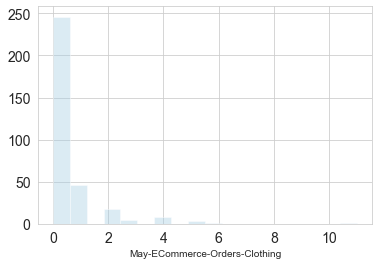

In [338]:
sns.distplot(sacog2018['May-ECommerce-Orders-Clothing'], kde = False)

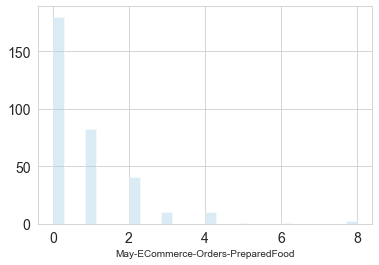

In [339]:
sns.distplot(sacog2018['May-ECommerce-Orders-PreparedFood'], kde = False)

In [56]:
sacog2018[['May-InStore-Trips-Groceries','to_grocery']].replace({-9998:0}).describe()

May-InStore-Trips-Groceries  to_grocery
count                      327.000     327.000
mean                         2.801       3.214
std                          2.090       3.001
min                          0.000       0.000
25%                          2.000       1.000
50%                          2.000       2.000
75%                          4.000       4.000
max                         11.000      17.000

In [541]:
noshop = sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] ==0) & (sacog2018['May-InStore-Trips-Groceries'] ==0)]
noshop[['May-InStore-Trips-Groceries','to_grocery']].describe()

May-InStore-Trips-Groceries  to_grocery
count                         21.0      21.000
mean                           0.0       2.048
std                            0.0       1.857
min                            0.0       0.000
25%                            0.0       1.000
50%                            0.0       2.000
75%                            0.0       2.000
max                            0.0       7.000

In [299]:
noshop = sacog2018[(sacog2018['May-ECommerce-Orders-PreparedFood'] ==0) & (sacog2018['May-InStore-Trips-PreparedFood'] ==0)]
noshop[['May-InStore-Trips-PreparedFood','to_meal']].describe()

May-InStore-Trips-PreparedFood  to_meal
count                           101.0  101.000
mean                              0.0    3.950
std                               0.0    4.348
min                               0.0    0.000
25%                               0.0    1.000
50%                               0.0    3.000
75%                               0.0    5.000
max                               0.0   23.000

In [536]:
instore = sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] ==0) & (sacog2018['May-InStore-Trips-Groceries'] !=0)]
instore[['May-InStore-Trips-Groceries','to_grocery']].describe()

May-InStore-Trips-Groceries  to_grocery
count                      235.000     235.000
mean                         3.170       3.243
std                          1.887       3.078
min                          1.000       0.000
25%                          2.000       1.000
50%                          2.000       2.000
75%                          4.000       5.000
max                         11.000      17.000

In [302]:
instore = sacog2018[(sacog2018['May-ECommerce-Orders-PreparedFood'] ==0) & (sacog2018['May-InStore-Trips-PreparedFood'] !=0)]
instore[['May-InStore-Trips-PreparedFood','to_meal']].describe()

May-InStore-Trips-PreparedFood  to_meal
count                          79.000   79.000
mean                            3.063    6.253
std                             2.138    5.438
min                             1.000    0.000
25%                             2.000    2.000
50%                             2.000    5.000
75%                             4.000    9.000
max                            11.000   30.000

In [545]:
online = sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] !=0) & (sacog2018['May-InStore-Trips-Groceries'] ==0)]
online[['May-InStore-Trips-Groceries','to_grocery']].describe()
online[['May-ECommerce-Orders-Groceries','May-ToHome-Groceries','May-Curbside-Groceries','May-InStore-Groceries']].replace({-9998:0}).describe()

May-ECommerce-Orders-Groceries  May-ToHome-Groceries  \
count                          20.000                20.000   
mean                            1.550                 1.300   
std                             0.826                 0.923   
min                             1.000                 0.000   
25%                             1.000                 1.000   
50%                             1.000                 1.000   
75%                             2.000                 2.000   
max                             3.000                 3.000   

       May-Curbside-Groceries  May-InStore-Groceries  
count                  20.000                 20.000  
mean                    0.150                  0.100  
std                     0.489                  0.308  
min                     0.000                  0.000  
25%                     0.000                  0.000  
50%                     0.000                  0.000  
75%                     0.000                  0.000  
max                     2.000                  1.000

In [301]:
online = sacog2018[(sacog2018['May-ECommerce-Orders-PreparedFood'] !=0) & (sacog2018['May-InStore-Trips-PreparedFood'] ==0)]
online[['May-InStore-Trips-PreparedFood','to_meal']].describe()
online[['May-ECommerce-Orders-PreparedFood','May-ToHome-PreparedFood','May-Curbside-PreparedFood','May-InStore-PreparedFood']].replace({-9998:0}).describe()

May-ECommerce-Orders-PreparedFood  May-ToHome-PreparedFood  \
count                             47.000                   47.000   
mean                               1.723                    0.894   
std                                1.378                    1.735   
min                                1.000                    0.000   
25%                                1.000                    0.000   
50%                                1.000                    0.000   
75%                                2.000                    1.000   
max                                8.000                   11.000   

       May-Curbside-PreparedFood  May-InStore-PreparedFood  
count                     47.000                    47.000  
mean                       0.596                     0.426  
std                        0.825                     0.853  
min                        0.000                     0.000  
25%                        0.000                     0.000  
50%                        0.000                     0.000  
75%                        1.000                     1.000  
max                        4.000                     5.000

In [547]:
both = sacog2018[(sacog2018['May-ECommerce-Orders-Groceries'] !=0) & (sacog2018['May-InStore-Trips-Groceries'] !=0)]
both[['May-InStore-Trips-Groceries','to_grocery']].describe()
both[['May-ECommerce-Orders-Groceries','May-ToHome-Groceries','May-Curbside-Groceries','May-InStore-Groceries']].replace({-9998:0}).describe()

May-InStore-Trips-Groceries  to_grocery
count                       51.000      51.000
mean                         3.353       3.431
std                          2.105       2.587
min                          1.000       0.000
25%                          2.000       2.000
50%                          2.000       3.000
75%                          4.000       4.000
max                         11.000      14.000

In [304]:
both = sacog2018[(sacog2018['May-ECommerce-Orders-PreparedFood'] !=0) & (sacog2018['May-InStore-Trips-PreparedFood'] !=0)]
both[['May-InStore-Trips-PreparedFood','to_meal']].describe()
both[['May-ECommerce-Orders-PreparedFood','May-ToHome-PreparedFood','May-Curbside-PreparedFood','May-InStore-PreparedFood']].replace({-9998:0}).describe()

May-ECommerce-Orders-PreparedFood  May-ToHome-PreparedFood  \
count                            100.000                  100.000   
mean                               1.800                    0.430   
std                                1.163                    0.868   
min                                1.000                    0.000   
25%                                1.000                    0.000   
50%                                1.000                    0.000   
75%                                2.000                    1.000   
max                                8.000                    4.000   

       May-Curbside-PreparedFood  May-InStore-PreparedFood  
count                    100.000                    100.00  
mean                       0.720                      1.05  
std                        0.889                      1.50  
min                        0.000                      0.00  
25%                        0.000                      0.00  
50%                        1.000                      1.00  
75%                        1.000                      1.25  
max                        5.000                     11.00

In [548]:
sacog2018[['May-ECommerce-Orders-Groceries','May-ToHome-Groceries','May-Curbside-Groceries','May-InStore-Groceries']].replace({-9998:0}).describe()

May-ECommerce-Orders-Groceries  May-ToHome-Groceries  \
count                         327.000               327.000   
mean                            0.355                 0.199   
std                             0.935                 0.537   
min                             0.000                 0.000   
25%                             0.000                 0.000   
50%                             0.000                 0.000   
75%                             0.000                 0.000   
max                            11.000                 3.000   

       May-Curbside-Groceries  May-InStore-Groceries  
count                 327.000                327.000  
mean                    0.107                  0.064  
std                     0.373                  0.312  
min                     0.000                  0.000  
25%                     0.000                  0.000  
50%                     0.000                  0.000  
75%                     0.000                  0.000  
max                     3.000                  3.000

tripmaking and basket sizes

In [551]:
sacog2018['Change-Shopping-TripsToStore-Groceries'].value_counts(),\
sacog2018['Change-Shopping-InStorePurchaseSize-Groceries'].value_counts()

(Less           195
 No change       87
 More            38
 No Response      7
 Name: Change-Shopping-TripsToStore-Groceries, dtype: int64, More           143
 No change      101
 Less            67
 No Response     16
 Name: Change-Shopping-InStorePurchaseSize-Groceries, dtype: int64)

In [560]:
len(sacog2018[(sacog2018['Change-Shopping-TripsToStore-Groceries'] == 'No change') & 
         (sacog2018['Change-Shopping-InStorePurchaseSize-Groceries'] == 'More')])

16

#### 4.4.7 2018 to 2020 commodity comparisons

In [60]:
stats = sacog2018[['to_grocery','to_meal','to_other_routine_shopping','delivery_athome','delivery_food']].describe()
stats = stats.append(sacog2018.reindex(stats.columns, axis=1).agg(['sum']))
stats

to_grocery   to_meal  to_other_routine_shopping  delivery_athome  \
count     327.000   327.000                    327.000          327.000   
mean        3.214     5.853                      3.202            1.606   
std         3.001     5.564                      3.490            1.939   
min         0.000     0.000                      0.000            0.000   
25%         1.000     2.000                      1.000            0.000   
50%         2.000     4.000                      2.000            1.000   
75%         4.000     9.000                      5.000            2.000   
max        17.000    36.000                     19.000           11.000   
sum      1051.000  1914.000                   1047.000          525.000   

       delivery_food  
count        327.000  
mean           0.131  
std            0.434  
min            0.000  
25%            0.000  
50%            0.000  
75%            0.000  
max            3.000  
sum           43.000

checking the 105% of prepared food ecommerce orders leading to trips

In [88]:
stats = sacog2018[['May-ECommerce-Orders-Medication','May-ToHome-Medication','May-Curbside-Medication','May-InStore-Medication']].replace({-9998:0}).describe()
stats = stats.append(sacog2018.replace({-9998:0}).reindex(stats.columns, axis=1).agg(['sum']))
stats.loc['sum']

May-ECommerce-Orders-Medication    86.0
May-ToHome-Medication              58.0
May-Curbside-Medication             5.0
May-InStore-Medication             26.0
Name: sum, dtype: float64

In [87]:
stats = sacog2018[['May-ECommerce-Orders-Clothing','May-ToHome-Clothing','May-Curbside-Clothing','May-InStore-Clothing']].replace({-9998:0}).describe()
stats = stats.append(sacog2018.replace({-9998:0}).reindex(stats.columns, axis=1).agg(['sum']))
stats.loc['sum']

May-ECommerce-Orders-Clothing    158.0
May-ToHome-Clothing              130.0
May-Curbside-Clothing             10.0
May-InStore-Clothing               2.0
Name: sum, dtype: float64

In [80]:
stats = sacog2018[['May-ECommerce-Orders-Groceries','May-ToHome-Groceries','May-Curbside-Groceries','May-InStore-Groceries']].replace({-9998:0}).describe()
stats = stats.append(sacog2018.replace({-9998:0}).reindex(stats.columns, axis=1).agg(['sum']))
stats

May-ECommerce-Orders-Groceries  May-ToHome-Groceries  \
count                         327.000               327.000   
mean                            0.355                 0.199   
std                             0.935                 0.537   
min                             0.000                 0.000   
25%                             0.000                 0.000   
50%                             0.000                 0.000   
75%                             0.000                 0.000   
max                            11.000                 3.000   
sum                           116.000                65.000   

       May-Curbside-Groceries  May-InStore-Groceries  
count                 327.000                327.000  
mean                    0.107                  0.064  
std                     0.373                  0.312  
min                     0.000                  0.000  
25%                     0.000                  0.000  
50%                     0.000                  0.000  
75%                     0.000                  0.000  
max                     3.000                  3.000  
sum                    35.000                 21.000

In [79]:
stats = sacog2018[['May-ECommerce-Orders-PreparedFood','May-ToHome-PreparedFood','May-Curbside-PreparedFood','May-InStore-PreparedFood']].replace({-9998:0}).describe()
stats = stats.append(sacog2018.replace({-9998:0}).reindex(stats.columns, axis=1).agg(['sum']))
stats

May-ECommerce-Orders-PreparedFood  May-ToHome-PreparedFood  \
count                            327.000                  327.000   
mean                               0.798                    0.272   
std                                1.209                    0.874   
min                                0.000                    0.000   
25%                                0.000                    0.000   
50%                                0.000                    0.000   
75%                                1.000                    0.000   
max                                8.000                   11.000   
sum                              261.000                   89.000   

       May-Curbside-PreparedFood  May-InStore-PreparedFood  
count                    327.000                   327.000  
mean                       0.398                     0.437  
std                        0.752                     1.052  
min                        0.000                     0.000  
25%                        0.000                     0.000  
50%                        0.000                     0.000  
75%                        1.000                     0.000  
max                        5.000                    11.000  
sum                      130.000                   143.000

#### 4.4.8 Other exploratory stuff

In [562]:
sacog2018['Rewards-Member-AmazonPrime'].describe(), sacog2018['Rewards-Length-AmazonPrime'].describe()

(count    327.000
 mean       0.768
 std        0.423
 min        0.000
 25%        1.000
 50%        1.000
 75%        1.000
 max        1.000
 Name: Rewards-Member-AmazonPrime, dtype: float64,
 count                     327
 unique                      6
 top       Longer than 5 years
 freq                      126
 Name: Rewards-Length-AmazonPrime, dtype: object)

In [563]:
prime_member = sacog2018.pivot_table(values = xtab2018,\
                   index = 'Rewards-Member-AmazonPrime', aggfunc = np.mean, dropna = True)
prime_member

May-ECommerce-Orders>0  May-Food-ECommerce-Orders  \
Rewards-Member-AmazonPrime                                                      
0                                            0.632                      0.658   
1                                            0.793                      1.478   

                            May-InStore-Trips-Groceries  \
Rewards-Member-AmazonPrime                                
0                                                 3.013   
1                                                 2.737   

                            May-InStore-Trips-NonFood  \
Rewards-Member-AmazonPrime                              
0                                               1.158   
1                                               1.558   

                            May-InStore-Trips-PreparedFood  \
Rewards-Member-AmazonPrime                                   
0                                                    1.908   
1                                                    1.677   

                            May-No-ECommerce-Orders  \
Rewards-Member-AmazonPrime                            
0                                             0.368   
1                                             0.207   

                            May-NonFood-ECommerce-Orders  delivery_athome  \
Rewards-Member-AmazonPrime                                                  
0                                                  0.711            0.908   
1                                                  1.853            1.817   

                            delivery_atwork  delivery_food  delivery_none  \
Rewards-Member-AmazonPrime                                                  
0                                     0.039          0.145          7.842   
1                                     0.088          0.127          8.279   

                            shoponline  to_grocery  to_meal  \
Rewards-Member-AmazonPrime                                    
0                                0.632       2.803    5.171   
1                                1.223       3.339    6.060   

                            to_other_routine_shopping  
Rewards-Member-AmazonPrime                             
0                                               3.026  
1                                               3.255

In [565]:
restaurant_member = sacog2018.pivot_table(values = xtab2018,\
                   index = 'Rewards-Member-RestaurantDelivery', aggfunc = np.mean, dropna = True)
restaurant_member

May-ECommerce-Orders>0  \
Rewards-Member-RestaurantDelivery                           
0                                                   0.745   
1                                                   0.848   

                                   May-Food-ECommerce-Orders  \
Rewards-Member-RestaurantDelivery                              
0                                                      1.170   
1                                                      2.333   

                                   May-InStore-Trips-Groceries  \
Rewards-Member-RestaurantDelivery                                
0                                                        2.782   
1                                                        2.970   

                                   May-InStore-Trips-NonFood  \
Rewards-Member-RestaurantDelivery                              
0                                                      1.429   
1                                                      1.788   

                                   May-InStore-Trips-PreparedFood  \
Rewards-Member-RestaurantDelivery                                   
0                                                           1.694   
1                                                           2.061   

                                   May-No-ECommerce-Orders  \
Rewards-Member-RestaurantDelivery                            
0                                                    0.255   
1                                                    0.152   

                                   May-NonFood-ECommerce-Orders  \
Rewards-Member-RestaurantDelivery                                 
0                                                         1.466   
1                                                         2.667   

                                   delivery_athome  delivery_atwork  \
Rewards-Member-RestaurantDelivery                                     
0                                            1.561            0.068   
1                                            2.000            0.152   

                                   delivery_food  delivery_none  shoponline  \
Rewards-Member-RestaurantDelivery                                             
0                                          0.119          8.190       1.068   
1                                          0.242          8.061       1.242   

                                   to_grocery  to_meal  \
Rewards-Member-RestaurantDelivery                        
0                                       3.255    5.752   
1                                       2.848    6.758   

                                   to_other_routine_shopping  
Rewards-Member-RestaurantDelivery                             
0                                                      3.201  
1                                                      3.212

In [564]:
grocery_member = sacog2018.pivot_table(values = xtab2018,\
                   index = 'Rewards-Member-GroceryDelivery', aggfunc = np.mean, dropna = True)
grocery_member

May-ECommerce-Orders>0  \
Rewards-Member-GroceryDelivery                           
0                                                0.748   
1                                                0.818   

                                May-Food-ECommerce-Orders  \
Rewards-Member-GroceryDelivery                              
0                                                   1.167   
1                                                   2.364   

                                May-InStore-Trips-Groceries  \
Rewards-Member-GroceryDelivery                                
0                                                     2.864   
1                                                     2.242   

                                May-InStore-Trips-NonFood  \
Rewards-Member-GroceryDelivery                              
0                                                   1.527   
1                                                   0.909   

                                May-InStore-Trips-PreparedFood  \
Rewards-Member-GroceryDelivery                                   
0                                                        1.769   
1                                                        1.394   

                                May-No-ECommerce-Orders  \
Rewards-Member-GroceryDelivery                            
0                                                 0.252   
1                                                 0.182   

                                May-NonFood-ECommerce-Orders  delivery_athome  \
Rewards-Member-GroceryDelivery                                                  
0                                                      1.449            1.568   
1                                                      2.818            1.939   

                                delivery_atwork  delivery_food  delivery_none  \
Rewards-Member-GroceryDelivery                                                  
0                                         0.078          0.126          8.354   
1                                         0.061          0.182          6.606   

                                shoponline  to_grocery  to_meal  \
Rewards-Member-GroceryDelivery                                    
0                                    1.041       3.177    5.759   
1                                    1.485       3.545    6.697   

                                to_other_routine_shopping  
Rewards-Member-GroceryDelivery                             
0                                                   3.241  
1                                                   2.848

In [566]:
sacog2018.columns.to_list()

['Unnamed: 0',
 'Start Date',
 'End Date',
 'Response Type',
 'IP Address',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'Recorded Date',
 'Response ID',
 'Recipient Last Name',
 'Recipient First Name',
 'Recipient Email',
 'External Data Reference',
 'Location Latitude',
 'Location Longitude',
 'Distribution Channel',
 'User Language',
 'Q_RecaptchaScore',
 'Participant Consent',
 'What is your age group?',
 'CountyofResidence',
 'Residence-ZipCode',
 'Residence-CrossStreet1',
 'Residence-CrossStreet2',
 'SACOG2018Method',
 'LiveWithHouseholdMember',
 'MovedSince2018',
 'County2018',
 'Recontacted',
 'OtherFollowups',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Me

## Part 5: For BTR

In [305]:
modes = ['May-InStore-Mode-PreparedFood','May-Pickup-Mode-PreparedFood',\
 'May-InStore-Mode-Groceries', 'May-Pickup-Mode-Groceries',\
 'May-InStore-Mode-OtherFood', 'May-Pickup-Mode-OtherFood',\
 'May-InStore-Mode-PaperCleaning', 'May-Pickup-Mode-PaperCleaning',\
 'May-InStore-Mode-Clothing', 'May-Pickup-Mode-Clothing',\
 'May-InStore-Mode-HomeOffice', 'May-Pickup-Mode-HomeOffice',\
 'May-InStore-Mode-Medication', 'May-Pickup-Mode-Medication',\
 'May-InStore-Mode-ChildcareItems', 'May-Pickup-Mode-ChildcareItems',\
 'May-InStore-Mode-Other', 'May-Pickup-Mode-Other']

In [329]:
sacog2018['May-Pickup-Mode-Other'].value_counts()

No Response        315
Drive alone          7
Some other mode      2
Walking              2
Carpool              1
Name: May-Pickup-Mode-Other, dtype: int64

In [196]:
mobility = pd.read_excel('sac_mobility.xlsx')

In [291]:
new_columns = mobility.columns.values
new_columns[3] = 'County'
new_columns[7] = 'Date'
new_columns[8] = 'Retail and Recreation % Change from Baseline'
new_columns[9] = 'Grocery and Pharmacy % Change from Baseline'
mobility.columns = new_columns
mobility

country_region_code country_region sub_region_1            County  \
0                     US  United States   California  El Dorado County   
1                     US  United States   California  El Dorado County   
2                     US  United States   California  El Dorado County   
3                     US  United States   California  El Dorado County   
4                     US  United States   California  El Dorado County   
...                  ...            ...          ...               ...   
1045                  US  United States   California       Yuba County   
1046                  US  United States   California       Yuba County   
1047                  US  United States   California       Yuba County   
1048                  US  United States   California       Yuba County   
1049                  US  United States   California       Yuba County   

      metro_area  iso_3166_2_code  census_fips_code       Date  \
0            NaN              NaN              6017 2020-02-15   
1            NaN              NaN              6017 2020-02-16   
2            NaN              NaN              6017 2020-02-17   
3            NaN              NaN              6017 2020-02-18   
4            NaN              NaN              6017 2020-02-19   
...          ...              ...               ...        ...   
1045         NaN              NaN              6115 2020-08-03   
1046         NaN              NaN              6115 2020-08-04   
1047         NaN              NaN              6115 2020-08-05   
1048         NaN              NaN              6115 2020-08-06   
1049         NaN              NaN              6115 2020-08-07   

      Retail and Recreation % Change from Baseline  \
0                                                2   
1                                               26   
2                                               25   
3                                               11   
4                                               10   
...                                            ...   
1045                                            -5   
1046                                            -5   
1047                                            -4   
1048                                           -11   
1049                                           -14   

      Grocery and Pharmacy % Change from Baseline  \
0                                            -5.0   
1                                             1.0   
2                                             0.0   
3                                             0.0   
4                                            -3.0   
...                                           ...   
1045                                         19.0   
1046                                         13.0   
1047                                         10.0   
1048                                         13.0   
1049                                         12.0   

      parks_percent_change_from_baseline  \
0                                   24.0   
1                                   95.0   
2                                  118.0   
3                                   34.0   
4                                   32.0   
...                                  ...   
1045                                 NaN   
1046                                 NaN   
1047                                 NaN   
1048                                 NaN   
1049                                 NaN   

      transit_stations_percent_change_from_baseline  \
0                                               NaN   
1                                               NaN   
2                                             -24.0   
3                                               NaN   
4                                             -12.0   
...                                             ...   
1045                                          -10.0   
1046                                           -4.0   
1047         

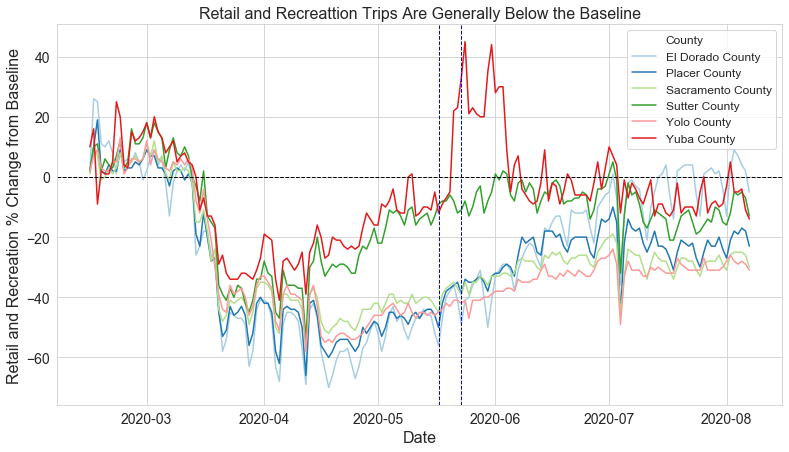

In [288]:
sns.set_style('whitegrid')
sns.set_palette('Paired')
f, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(x = 'Date', y = 'Retail and Recreation % Change from Baseline',\
                hue = 'County', data = mobility, ax = ax)
ax.axvline(x='2020-05-17', color = 'b', linestyle = '--', linewidth = 1)
ax.axvline(x='2020-05-23', color = 'b', linestyle = '--', linewidth = 1)
ax.axhline(y=0, color = 'k', linestyle = '--', linewidth = 1)

##
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.legend(loc = 1, fontsize=12)
ax.set_title('Retail and Recreattion Trips Are Generally Below the Baseline', fontsize = 16);

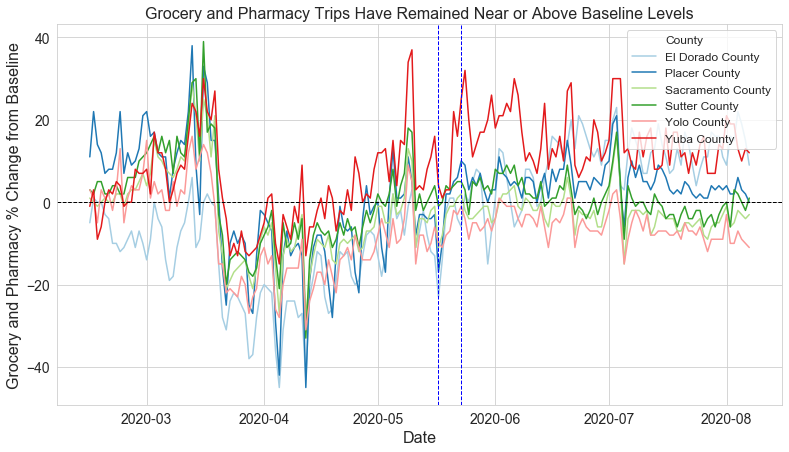

In [290]:
f, ax = plt.subplots(figsize=(13, 7))

sns.lineplot(x = 'Date', y = 'Grocery and Pharmacy % Change from Baseline',\
                hue = 'County', data = mobility, ax = ax)
ax.axvline(x='2020-05-17', color = 'b', linestyle = '--', linewidth = 1)
ax.axvline(x='2020-05-23', color = 'b', linestyle = '--', linewidth = 1)
ax.axhline(y=0, color = 'k', linestyle = '--', linewidth = 1)

##
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.legend(loc = 1, fontsize=12)
ax.set_title('Grocery and Pharmacy Trips Have Remained Near or Above Baseline Levels', fontsize = 16);

## Part 6: Spatial Stuff

In [352]:
## importing from geojson saves a bit of time
gdf = gpd.read_file("gdf.geojson")

In [353]:
pop_stats = pd.read_csv('ACSDT5Y2017.B01003_data_with_overlays_2020-08-05T123457.csv')

In [354]:
## make a matching column in each dataset
gdf['geoid_match'] = [x[5:] for x in gdf.GEOID_Data]
pop_stats['geoid_match'] = [x[7:] for x in pop_stats.GEO_ID]

matched = gdf.merge(pop_stats, on = 'geoid_match')
## move to a readable projection for plotting
matched = matched.to_crs(epsg=3857)

/Users/ehforscher/Library/Python/3.7/lib/python/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [355]:
len(matched)

1153

In [357]:
rMoves.columns.to_list()

['hhidR_x',
 'to_grocery',
 'to_other_routine_shopping',
 'to_meal',
 'to_work',
 'to_school',
 'to_leisure_ent',
 'to_social',
 'to_recreation',
 'delivery_athome',
 'delivery_atwork',
 'delivery_food',
 'delivery_none',
 'shoponline',
 'rTed',
 'pernum_x',
 'hh_group_x',
 'rmove_participant',
 'smartphone_type',
 'relationship',
 'gender',
 'age',
 'employment',
 'job_type',
 'jobs_count',
 'student',
 'schooltype',
 'education',
 'license',
 'disability',
 'ethnicity_aiak',
 'ethnicity_asian',
 'ethnicity_afam',
 'ethnicity_hisp',
 'ethnicity_mideast',
 'ethnicity_hapi',
 'ethnicity_white',
 'ethnicity_other',
 'ethnicity_noanswer',
 'ethnicity_multi',
 'share_driveuberlyft',
 'tnc_freq',
 'work_mode',
 'work_dist_mi',
 'school_mode',
 'school_bus',
 'other_school',
 'school_dist_mi',
 'p_secondhome',
 'hhsize',
 'hhveh',
 'numadults',
 'numkids',
 'numworkers',
 'num_rmove_participants',
 'res_duration',
 'res_type',
 'rent_own',
 'res_months',
 'hh_secondhome',
 'income_broad',
 '

In [367]:
matched['geoid_rmoves'] = [x[3:] for x in matched.geoid_match]
matched['geoid_rmoves'] = matched['geoid_rmoves'].astype('int')

rMoves = matched.merge(rMoves, left_on = 'geoid_rmoves', right_on = 'reported_bg')

sacog2018_map = matched.merge(sacog2018, left_on = 'geoid_rmoves', right_on = 'reported_bg')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


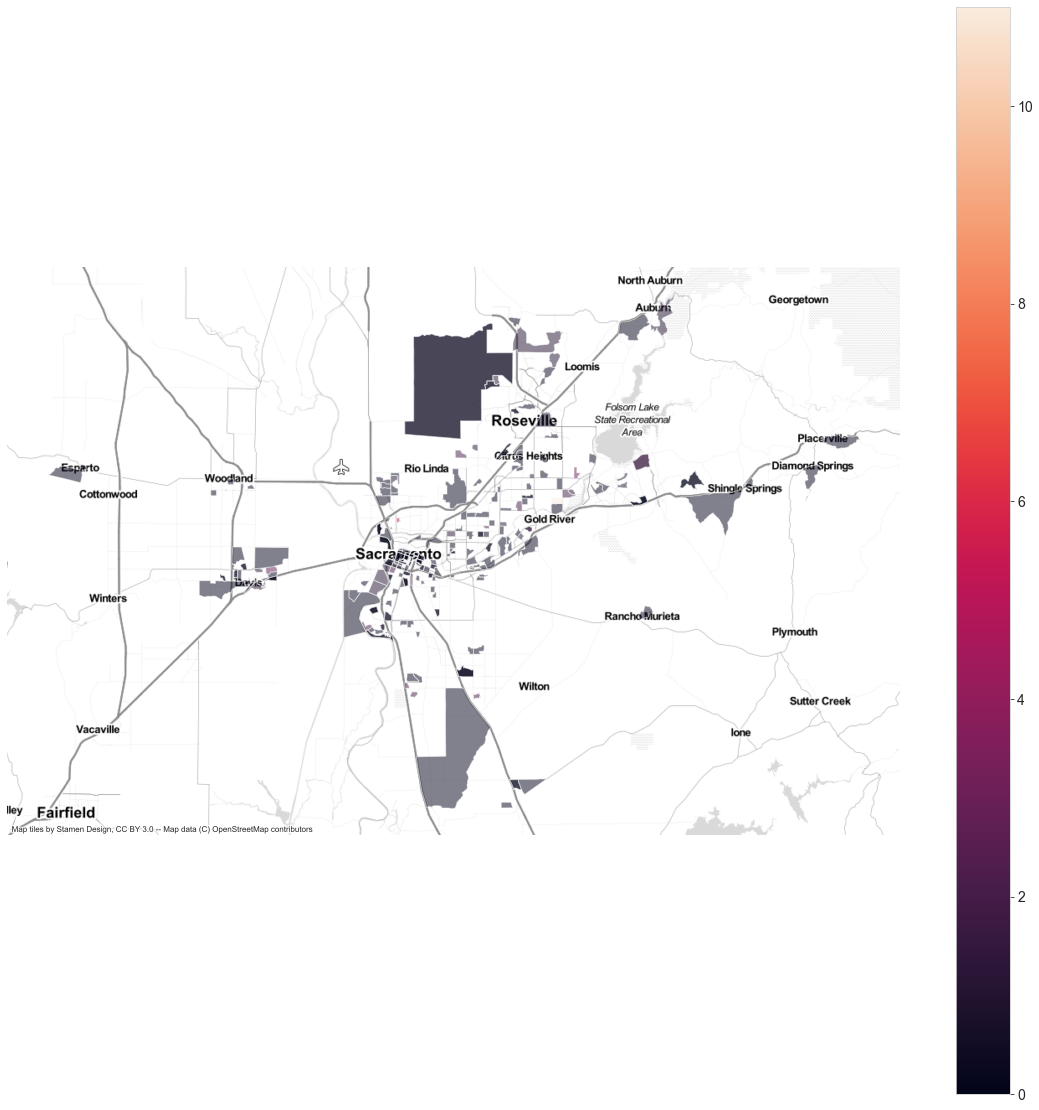

In [372]:
f, ax = plt.subplots(figsize=(20, 20))
sacog2018_map.replace({-9998:0}).plot(column = 'May-ECommerce-Orders-Groceries', legend = True, ax = ax, alpha = .5)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [388]:
sacog2018.columns.to_list()

['Unnamed: 0',
 'Start Date',
 'End Date',
 'Response Type',
 'IP Address',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'Recorded Date',
 'Response ID',
 'Recipient Last Name',
 'Recipient First Name',
 'Recipient Email',
 'External Data Reference',
 'Location Latitude',
 'Location Longitude',
 'Distribution Channel',
 'User Language',
 'Q_RecaptchaScore',
 'Participant Consent',
 'What is your age group?',
 'CountyofResidence',
 'Residence-ZipCode',
 'Residence-CrossStreet1',
 'Residence-CrossStreet2',
 'SACOG2018Method',
 'LiveWithHouseholdMember',
 'MovedSince2018',
 'County2018',
 'Recontacted',
 'OtherFollowups',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Me

In [389]:
sacog2018['May-InStore-Distance-Groceries'].value_counts()

1 - 3 miles              105
3 - 5 miles               53
5 -10 miles               39
No Response               38
1/2 mile - 1 mile         32
10 - 25 miles             25
Less than 1/4 mile        15
1/4 - 1/2 mile            13
25 - 50 miles              5
Greater than 50 miles      2
Name: May-InStore-Distance-Groceries, dtype: int64

In [391]:
sacog2018['Change-Shopping-TripDistanceToStore-Groceries'].value_counts()

No change      251
Less            32
No Response     26
More            18
Name: Change-Shopping-TripDistanceToStore-Groceries, dtype: int64

In [ ]:
sacog2018['May-InStore-Distance-Groceries'].value_counts()

In [390]:
sacog2018['May-InStore-Distance-PreparedFood'].value_counts()

No Response           140
1 - 3 miles            68
3 - 5 miles            46
1/2 mile - 1 mile      19
5 -10 miles            19
1/4 - 1/2 mile         15
Less than 1/4 mile      9
10 - 25 miles           9
25 - 50 miles           2
Name: May-InStore-Distance-PreparedFood, dtype: int64

In [392]:
sacog2018['Change-Shopping-TripDistanceToStore-PreparedFood'].value_counts()

No change      259
Less            31
No Response     25
More            12
Name: Change-Shopping-TripDistanceToStore-PreparedFood, dtype: int64

In [404]:
sacog2018.pivot(values = ['May-InStore-Distance-Groceries','Change-Shopping-TripDistanceToStore-Groceries'],\
                   columns = 'Change-Shopping-TripsToStore-Groceries')

May-InStore-Distance-Groceries  \
Change-Shopping-TripsToStore-Groceries                           Less   
0                                                                 NaN   
1                                                                 NaN   
2                                                                 NaN   
3                                                      1/4 - 1/2 mile   
4                                                                 NaN   
..                                                                ...   
322                                                       3 - 5 miles   
323                                                       No Response   
324                                                       1 - 3 miles   
325                                                       1 - 3 miles   
326                                                               NaN   

                                                                       \
Change-Shopping-TripsToStore-Groceries               More No Response   
0                                                     NaN         NaN   
1                                                     NaN         NaN   
2                                                     NaN         NaN   
3                                                     NaN         NaN   
4                                       1/2 mile - 1 mile         NaN   
..                                                    ...         ...   
322                                                   NaN         NaN   
323                                                   NaN         NaN   
324                                                   NaN         NaN   
325                                                   NaN         NaN   
326                                                   NaN         NaN   

                                                       \
Change-Shopping-TripsToStore-Groceries      No change   
0                                         5 -10 miles   
1                                         5 -10 miles   
2                                         1 - 3 miles   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
322                                               NaN   
323                                               NaN   
324                                               NaN   
325                                               NaN   
326                                     10 - 25 miles   

                                       Change-Shopping-TripDistanceToStore-Groceries  \
Change-Shopping-TripsToStore-Groceries                                          Less   
0                                                                                NaN   
1                                                                                NaN   
2                                                                                NaN   
3                                                                          No change   
4                                                                                NaN   
..                                                                               ...   
322                                                                        No change   
323                                                                        No change   
324                                                                        No change   
325                                                                        No change   
326                                                                              NaN   

                                                                          
Change-Shopping-TripsToStore-Groceries       More No Response  No change  
0                                             NaN         NaN  No change  
1                          

In [405]:
def crosstab_count(df, col1, col2):
    return df.melt(id_vars = col1, value_vars = col2).rename(columns = {'value':col2}).pivot_table(index = col1, columns = col2, aggfunc = 'count').fillna(0).astype(int).droplevel(level=0,axis=1)

In [408]:
crosstab_count(sacog2018,'Change-Shopping-TripsToStore-Groceries','Change-Shopping-TripDistanceToStore-Groceries')

Change-Shopping-TripDistanceToStore-Groceries  Less  More  No Response  \
Change-Shopping-TripsToStore-Groceries                                   
Less                                             31     7           13   
More                                              1     8            1   
No Response                                       0     0            5   
No change                                         0     3            7   

Change-Shopping-TripDistanceToStore-Groceries  No change  
Change-Shopping-TripsToStore-Groceries                    
Less                                                 144  
More                                                  28  
No Response                                            2  
No change                                             77